In [39]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import collections
from collections import Counter
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from imblearn.under_sampling import RandomUnderSampler
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import seaborn as sns
from tensorflow.keras.optimizers import Adam
import json

import torch
import os

**BATCH SIZE DAN SPLIT MANUAL**

In [44]:
# Set global seed dan GPU
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

os.environ['PYTHONHASHSEED'] = str(seed)
tf.keras.utils.set_random_seed(seed)

tf.config.threading.set_intra_op_parallelism_threads(1)

tf.keras.mixed_precision.set_global_policy('float32')

In [45]:
def load_dataset(data_dir, image_size, batch_size, seed):
    """Memuat dataset dari direktori."""
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=image_size,
        batch_size=batch_size,
        seed=seed
    )
    return dataset

def stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed):
    """Membagi dataset dengan metode stratified sampling."""
    # Unbatch dataset
    unbatched_ds = list(dataset.unbatch())
    images, labels = zip(*[(img.numpy(), label.numpy()) for img, label in unbatched_ds])
    images = np.array(images)
    labels = np.array(labels)

    if sample_size is None:
        images_resampled = images
        labels_resampled = labels
    else:
        # Under-sampling setiap label sesuai sample_size
        rus = RandomUnderSampler(
            sampling_strategy={i: sample_size for i in np.unique(labels)}, 
            random_state=seed
        )
        images_resampled, labels_resampled = rus.fit_resample(images.reshape((images.shape[0], -1)), labels)
        images_resampled = images_resampled.reshape((-1, *image_size, 3))

    # Split dataset menjadi data latih dan validasi
    train_images, val_images, train_labels, val_labels = train_test_split(
        images_resampled,
        labels_resampled,
        test_size=split_ratio,
        random_state=seed,
        stratify=labels_resampled
    )

    # convert kembali ke format dataset TensorFlow
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)

    return train_ds, val_ds

def data_augmentation(train_ds, augmentation_factor, batch_size):
    """Melakukan augmentasi data pada dataset latih."""
    # Membuat layer augmentasi
    random_flip = RandomFlip("horizontal_and_vertical", seed=seed)
    random_rotation = RandomRotation(factor=(90 / 360), seed=seed)
    random_zoom = RandomZoom(0.2, seed=seed)
    random_contrast = RandomContrast(0.2, seed=seed)

    @tf.function
    def augment_image(image, label):
        image = random_flip(image)
        image = random_rotation(image)
        image = random_zoom(image)
        image = random_contrast(image)
        return image, label

    num_augmented_samples = int(len(list(train_ds.unbatch())) * augmentation_factor)
    augmented_ds = train_ds.unbatch().take(num_augmented_samples).map(augment_image).batch(batch_size)
    train_ds_aug = train_ds.concatenate(augmented_ds)
    
    return train_ds_aug

def build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6):
    """Membuat arsitektur model dengan EfficientNetV2."""
    base_model = efficientnet_v2.EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    base_model.trainable = False

    model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(neuron, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    BatchNormalization(),
    Dropout(dropout_rate, seed=seed),
    Dense(num_classes, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
    ])

    model.summary()

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

def train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6):
    """training model dan evaluasi."""
    checkpoint = ModelCheckpoint(
        f'best_model_{name}.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    
    # Training
    history = model.fit(
        train_ds_aug,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[checkpoint],
        verbose=1
    )
    
    # Simpan model terakhir/full model
    model.save(f'full_model_{name}.keras')

    # Simpan history pelatihan dalam format JSON
    with open(f'history_{name}.json', 'w') as f:
        json.dump(history.history, f)

    # Load best model
    best_model = keras.models.load_model(f'best_model_{name}.keras')
    val_loss, val_accuracy = best_model.evaluate(val_ds)

    # Mendapatkan epoch terbaik
    best_val_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_train_accuracy = max(history.history['accuracy'])

    # Print hasil evaluasi
    print(f"Model saved at Epoch: {best_val_epoch}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Training Accuracy: {best_train_accuracy:.4f}")


    # Membuat prediksi
    y_pred_prob = best_model.predict(val_ds)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    class_names = dataset.class_names

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=class_names, 
                yticklabels=class_names,
                annot_kws={"size": 16}),
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=18)
    plt.ylabel('True Label', fontsize=18)
    plt.xticks(fontsize=16, rotation=45)
    plt.yticks(fontsize=16)
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))  # Menggunakan nama label

    # Hitung accuracy
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"Accuracy: {accuracy:.4f}")

    # Hitung ROC dan AUC per kelas
    y_true_binary = to_categorical(y_true, num_classes=num_classes)
    auc = roc_auc_score(y_true_binary, y_pred_prob, multi_class="ovr")
    print(f"ROC AUC Score: {auc:.4f}")

    # Plot ROC per kelas
    fpr = {}
    tpr = {}
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_prob[:, i])
        auc_score = roc_auc_score(y_true_binary[:, i], y_pred_prob[:, i])
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {auc_score:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC Curve for Each Class', fontsize=20)
    plt.legend(loc='lower right', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

    # Plot akurasi dan validasi
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.plot(best_val_epoch - 1, history.history['val_accuracy'][best_val_epoch - 1], 'ro', label='Best Validation Accuracy', markersize=8)
    plt.title('Accuracy Over Epochs', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()
    
    # Plot loss
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.plot(best_val_epoch - 1, history.history['val_loss'][best_val_epoch - 1], 'ro', label='Loss at Best Validation Accuracy', markersize=8)
    plt.title('Loss Over Epochs', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.legend(fontsize=18) 
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

In [46]:
data_dir = "archive/Tea_Leaf_Disease"

**BASE**

In [ ]:
sample_size = 250
image_size = (384, 384)
split_ratio = 0.2
neuron = 512
batch_size = 64
augmentation_factor = 0.6
dropout_rate = 0.3
learning_rate = 0.001
epochs = 15

Found 5867 files belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
               

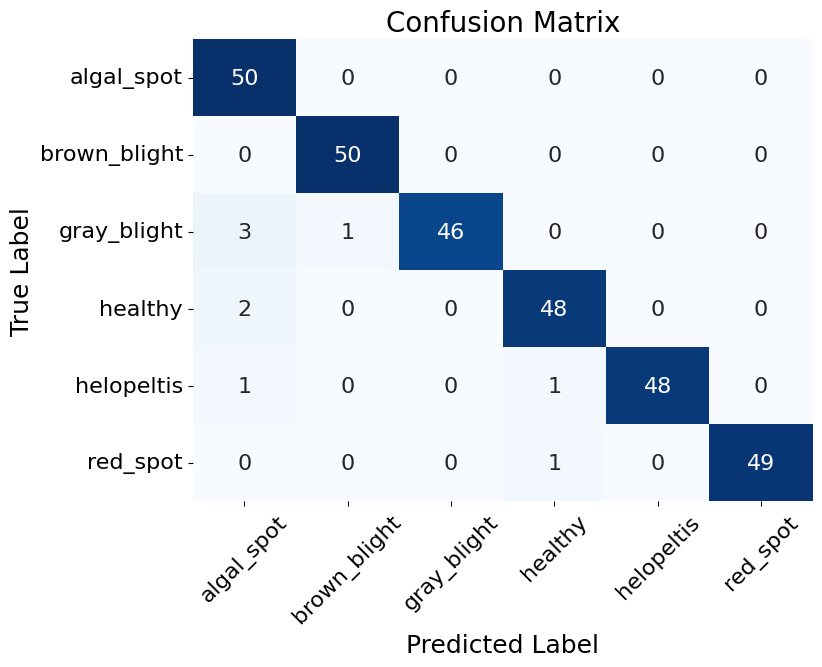

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.8929    1.0000    0.9434        50
brown_blight     0.9804    1.0000    0.9901        50
 gray_blight     1.0000    0.9200    0.9583        50
     healthy     0.9600    0.9600    0.9600        50
  helopeltis     1.0000    0.9600    0.9796        50
    red_spot     1.0000    0.9800    0.9899        50

    accuracy                         0.9700       300
   macro avg     0.9722    0.9700    0.9702       300
weighted avg     0.9722    0.9700    0.9702       300

Accuracy: 0.9700
ROC AUC Score: 0.9962


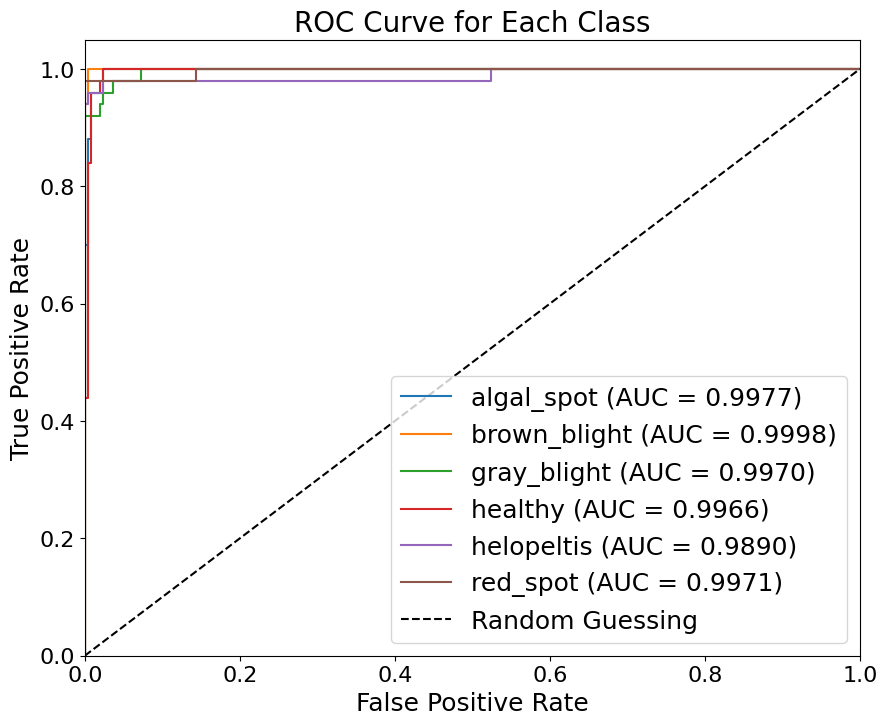

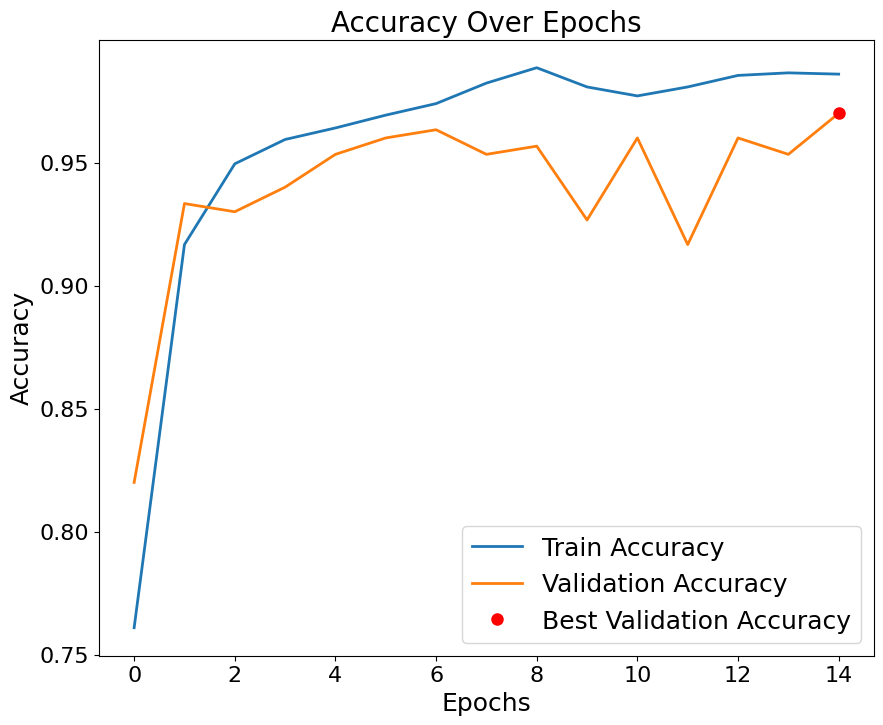

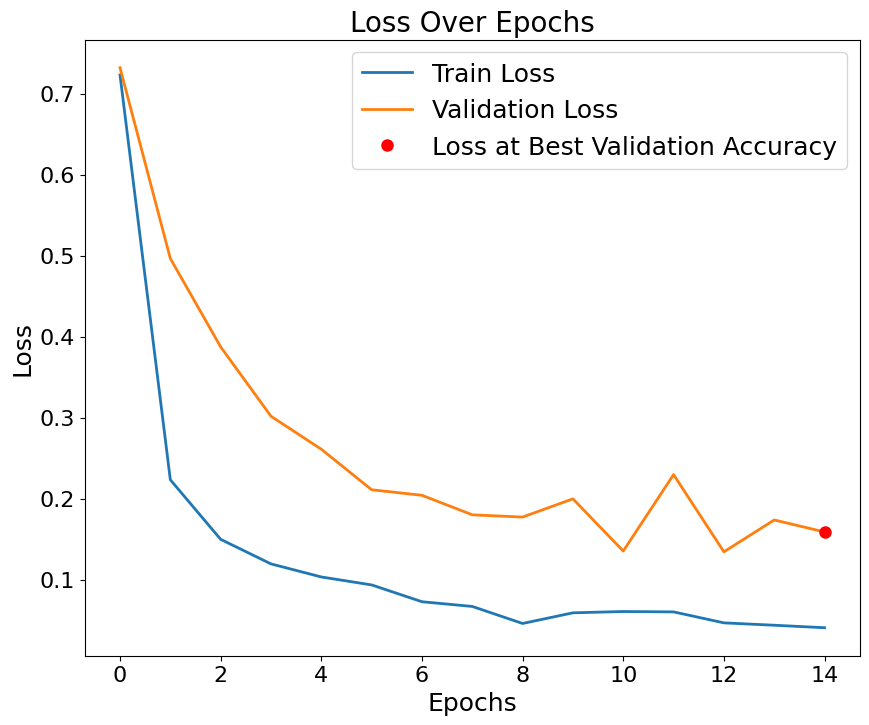

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [31]:
name = 'base'

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

**TUNNING**

**1. SPLIT**

split 0.2

Found 5867 files belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
               

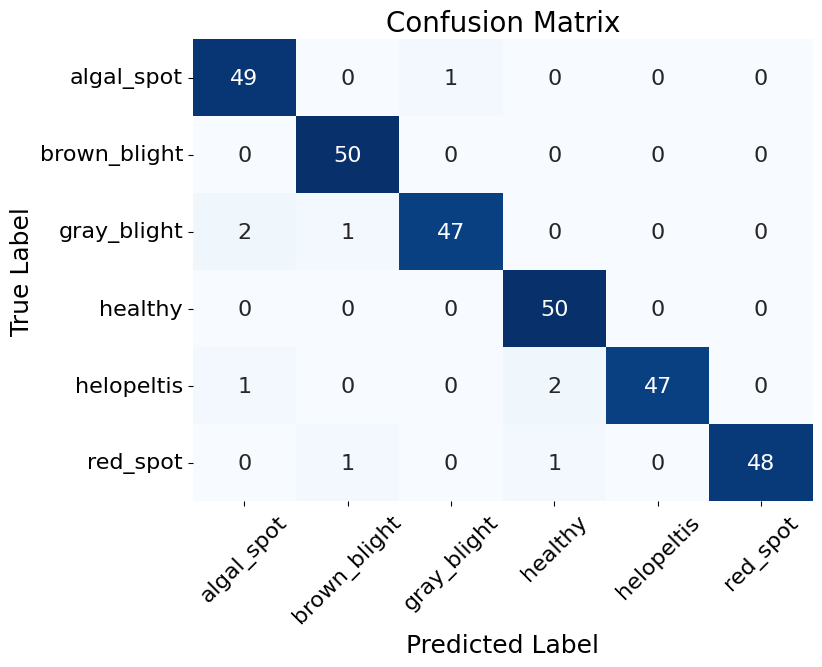

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9423    0.9800    0.9608        50
brown_blight     0.9615    1.0000    0.9804        50
 gray_blight     0.9792    0.9400    0.9592        50
     healthy     0.9434    1.0000    0.9709        50
  helopeltis     1.0000    0.9400    0.9691        50
    red_spot     1.0000    0.9600    0.9796        50

    accuracy                         0.9700       300
   macro avg     0.9711    0.9700    0.9700       300
weighted avg     0.9711    0.9700    0.9700       300

Accuracy: 0.9700
ROC AUC Score: 0.9962


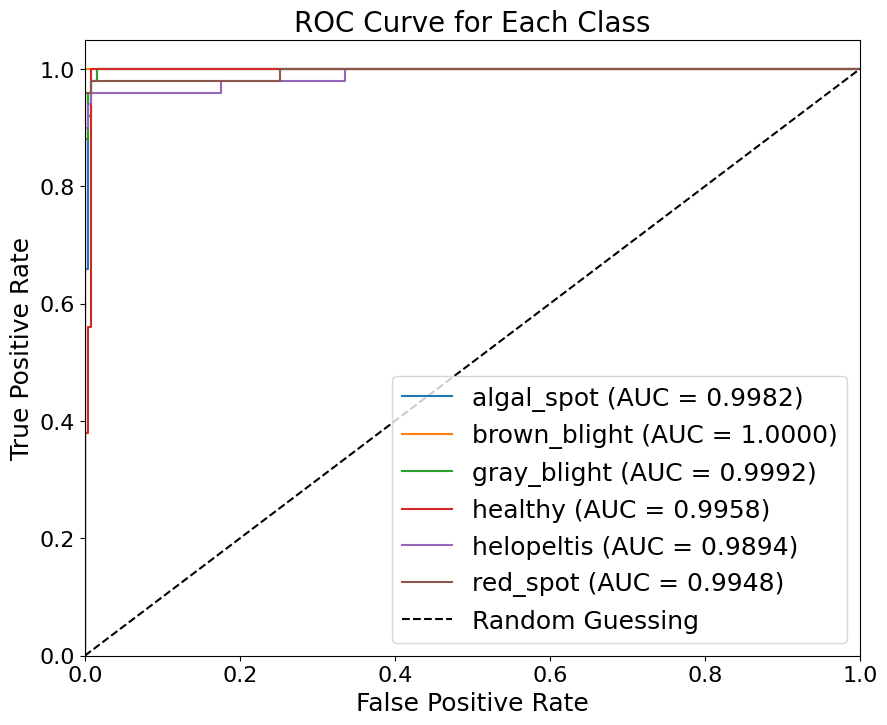

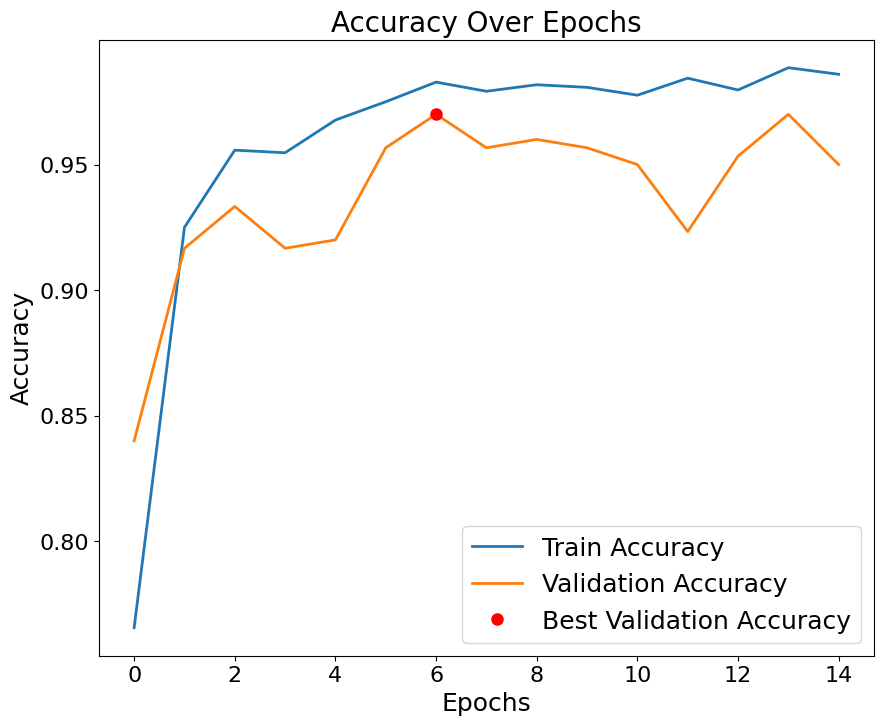

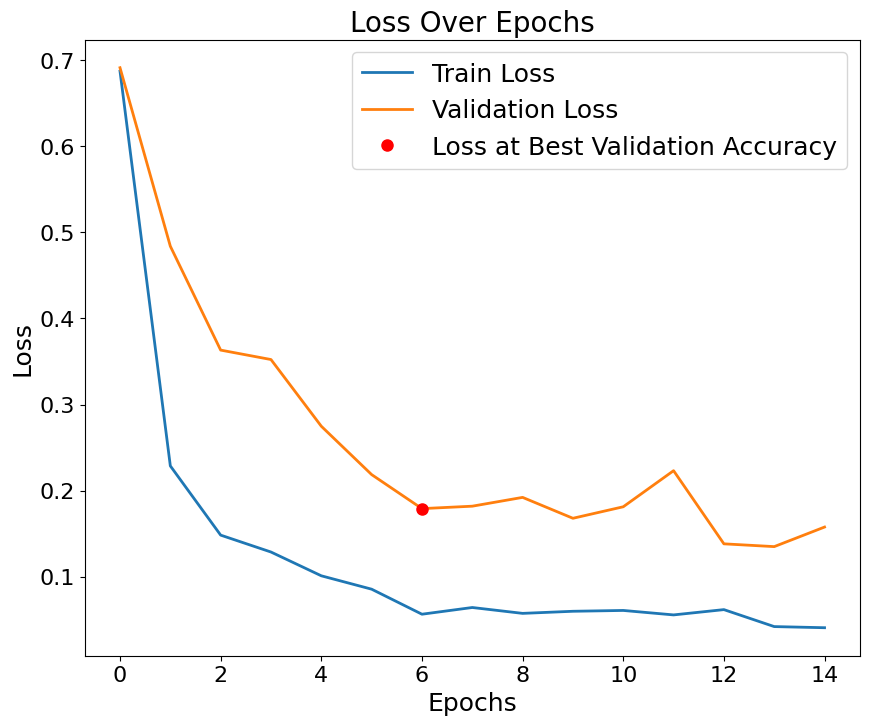

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [ ]:
split_ratio = 0.2
name = f'split_ratio_{split_ratio}'

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

split 0.25

Found 5867 files belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
               

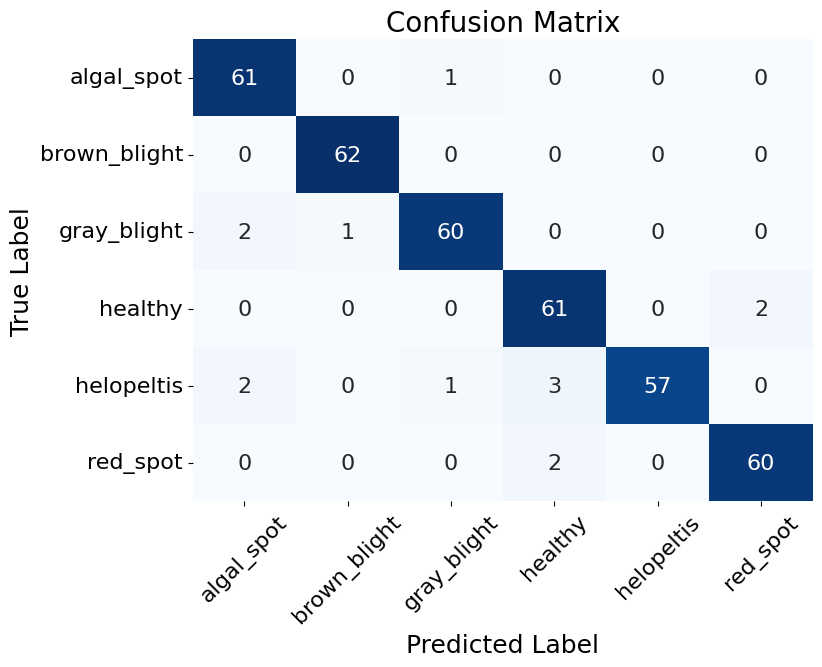

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9385    0.9839    0.9606        62
brown_blight     0.9841    1.0000    0.9920        62
 gray_blight     0.9677    0.9524    0.9600        63
     healthy     0.9242    0.9683    0.9457        63
  helopeltis     1.0000    0.9048    0.9500        63
    red_spot     0.9677    0.9677    0.9677        62

    accuracy                         0.9627       375
   macro avg     0.9637    0.9628    0.9627       375
weighted avg     0.9637    0.9627    0.9626       375

Accuracy: 0.9627
ROC AUC Score: 0.9980


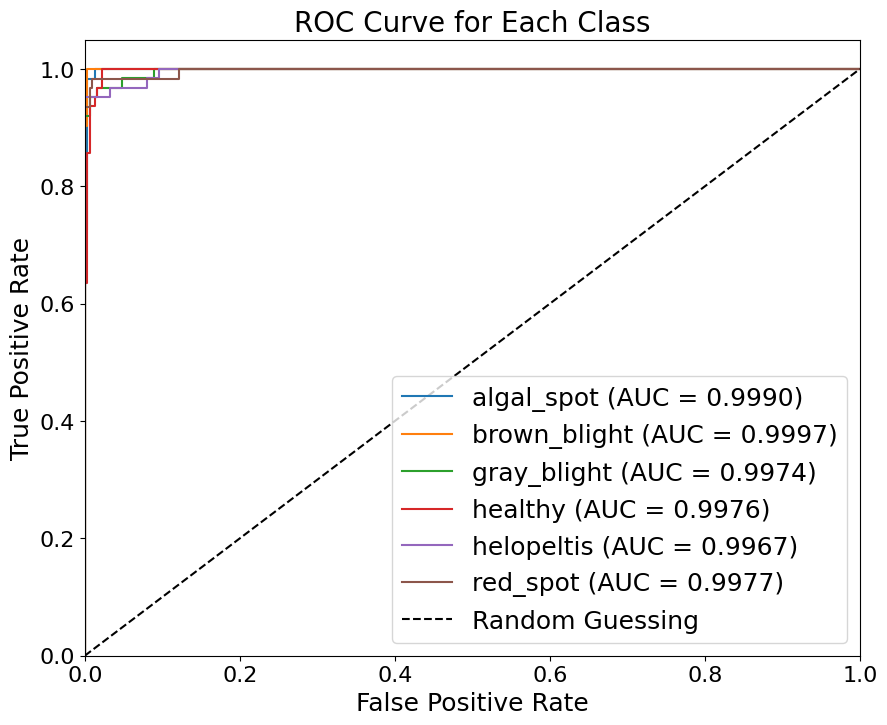

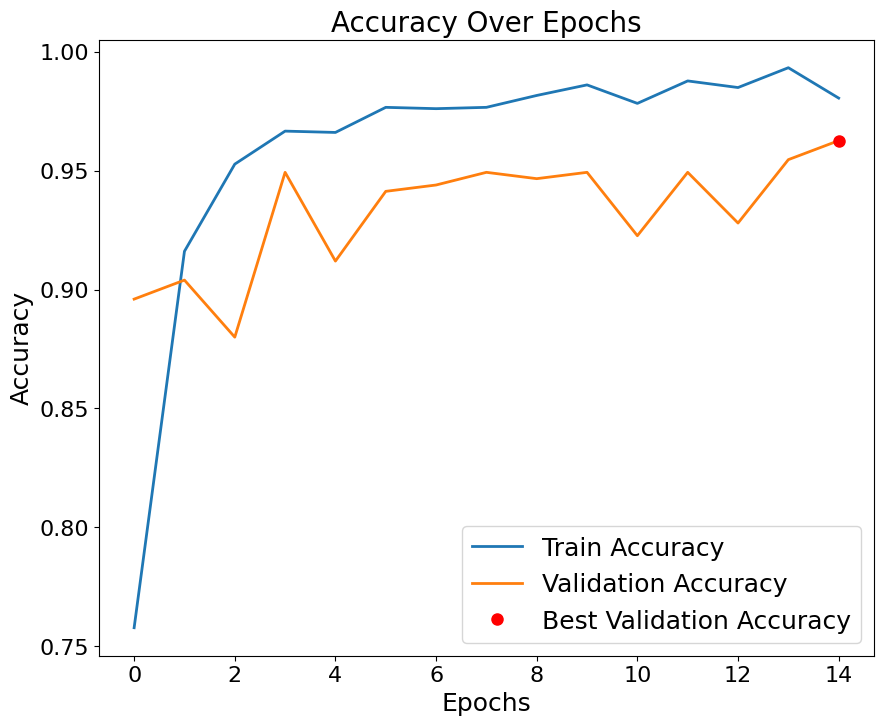

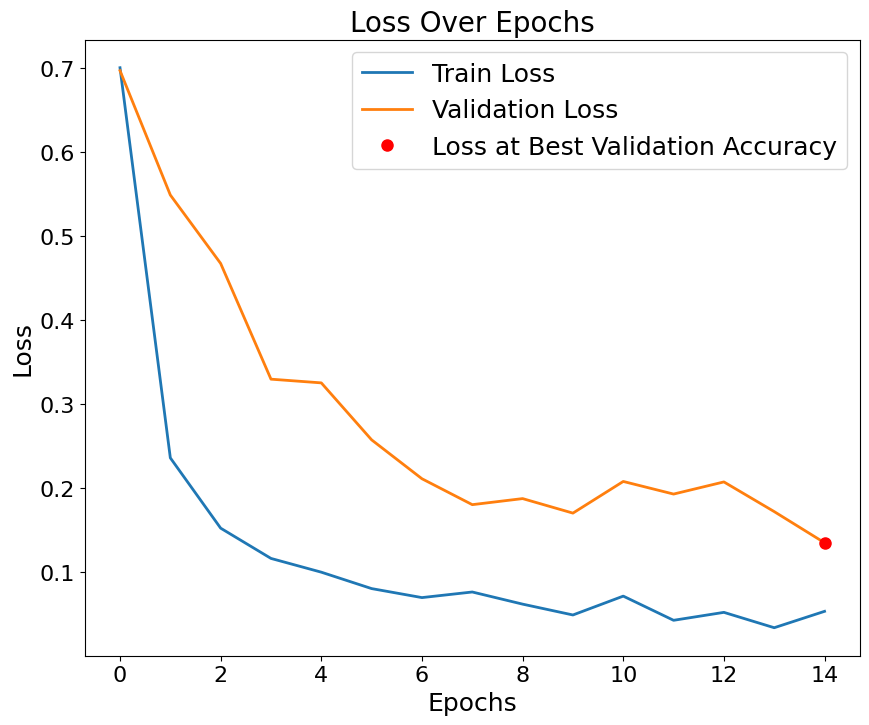

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [38]:
split_ratio = 0.25
name = f'split_ratio_{split_ratio}'

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

split 0.3

Found 5867 files belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
               

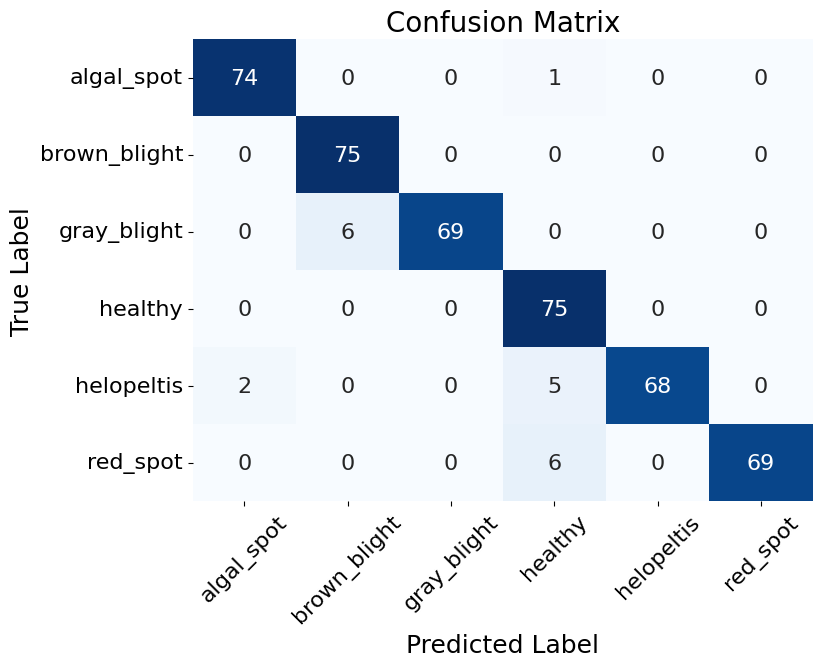

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9737    0.9867    0.9801        75
brown_blight     0.9259    1.0000    0.9615        75
 gray_blight     1.0000    0.9200    0.9583        75
     healthy     0.8621    1.0000    0.9259        75
  helopeltis     1.0000    0.9067    0.9510        75
    red_spot     1.0000    0.9200    0.9583        75

    accuracy                         0.9556       450
   macro avg     0.9603    0.9556    0.9559       450
weighted avg     0.9603    0.9556    0.9559       450

Accuracy: 0.9556
ROC AUC Score: 0.9979


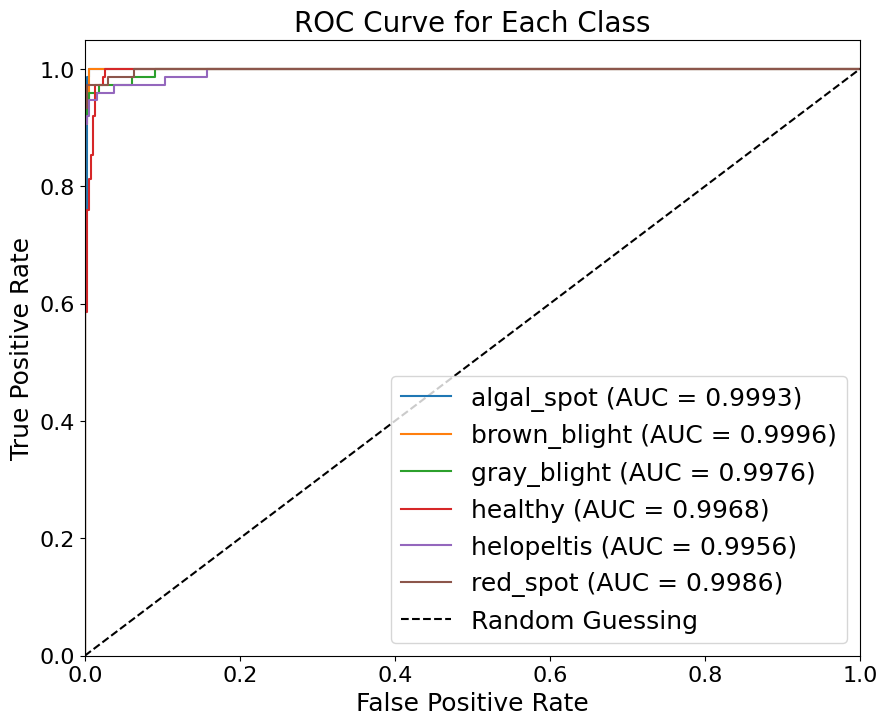

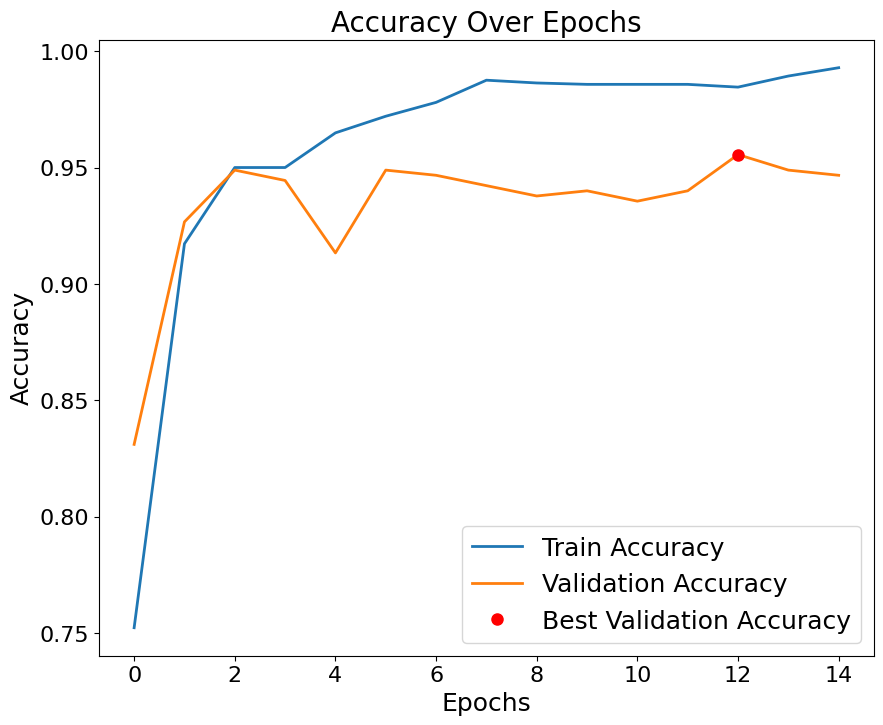

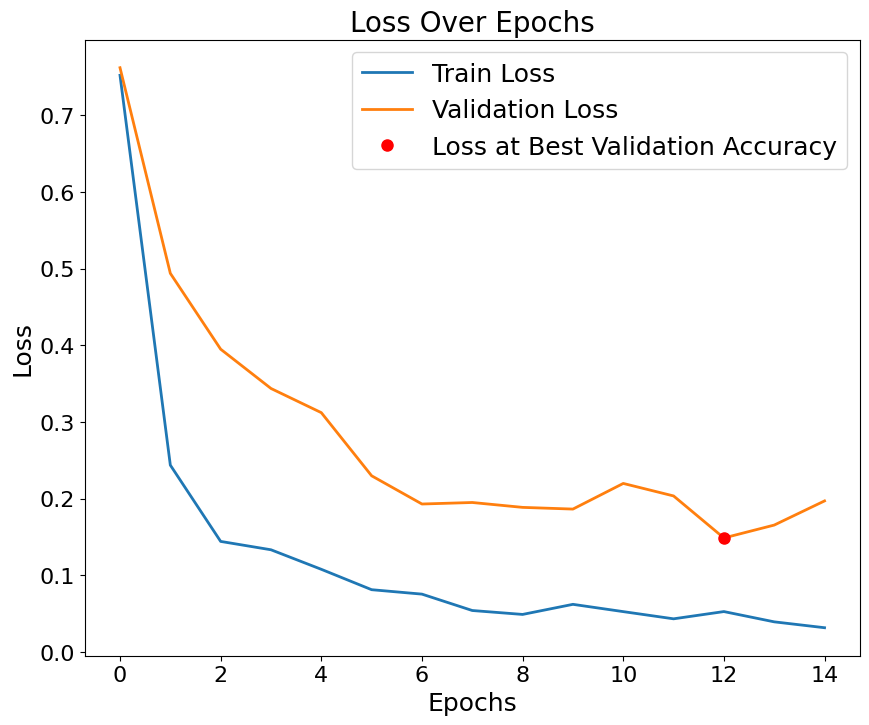

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [42]:
split_ratio = 0.3
name = f'split_ratio_{split_ratio}'

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

**PREPROCESSING & PREPARATION**

In [12]:
split_ratio = 0.2

In [13]:
dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

Found 5867 files belonging to 6 classes.


**2. LEARNING RATE**

learning rate 0.01

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

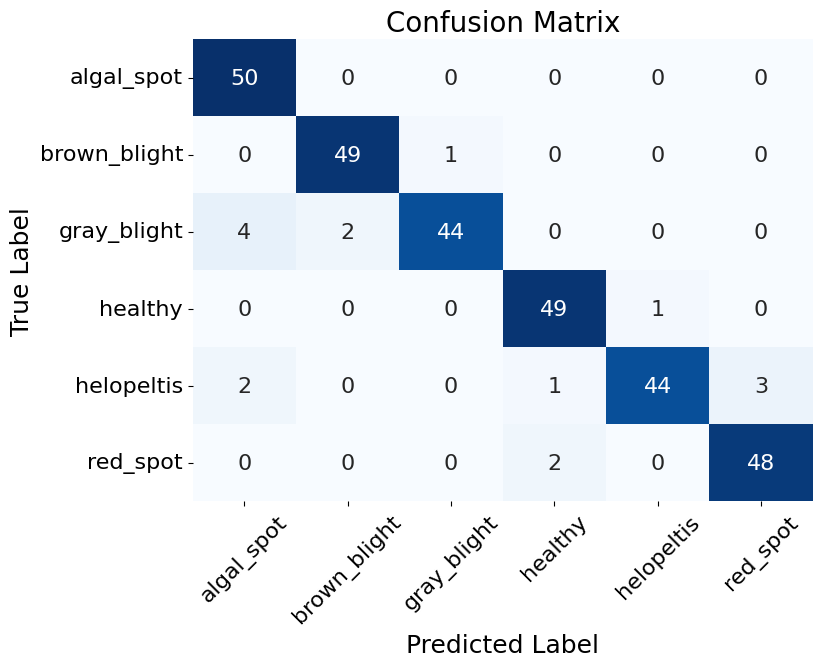

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.8929    1.0000    0.9434        50
brown_blight     0.9608    0.9800    0.9703        50
 gray_blight     0.9778    0.8800    0.9263        50
     healthy     0.9423    0.9800    0.9608        50
  helopeltis     0.9778    0.8800    0.9263        50
    red_spot     0.9412    0.9600    0.9505        50

    accuracy                         0.9467       300
   macro avg     0.9488    0.9467    0.9463       300
weighted avg     0.9488    0.9467    0.9463       300

Accuracy: 0.9467
ROC AUC Score: 0.9934


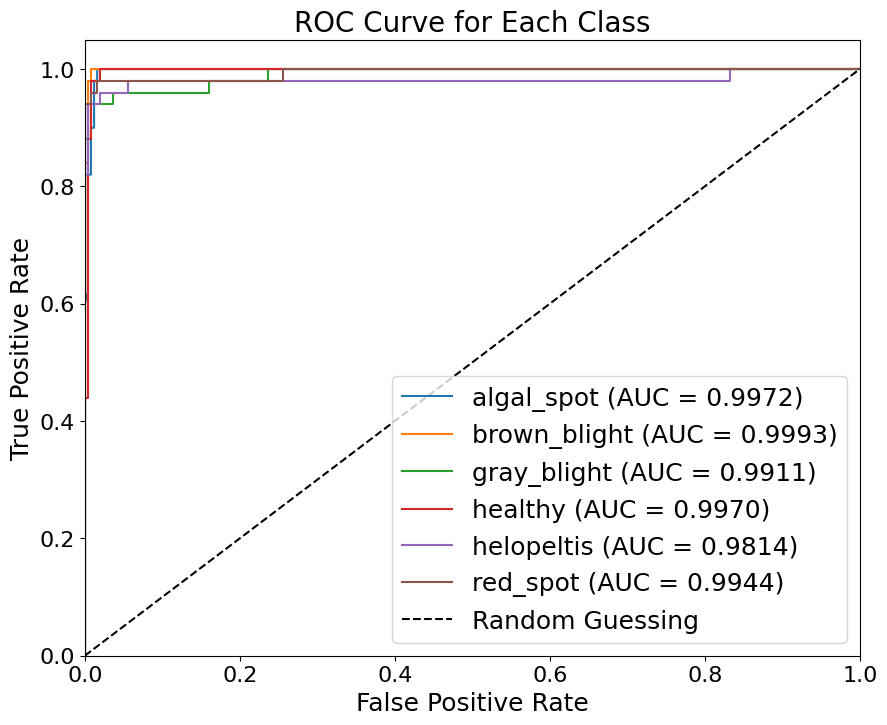

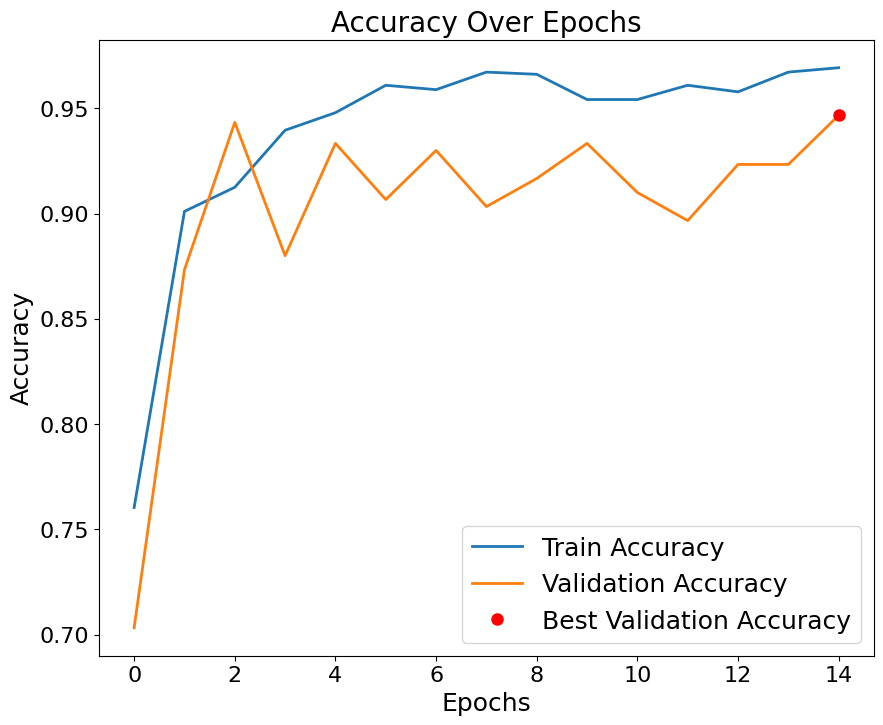

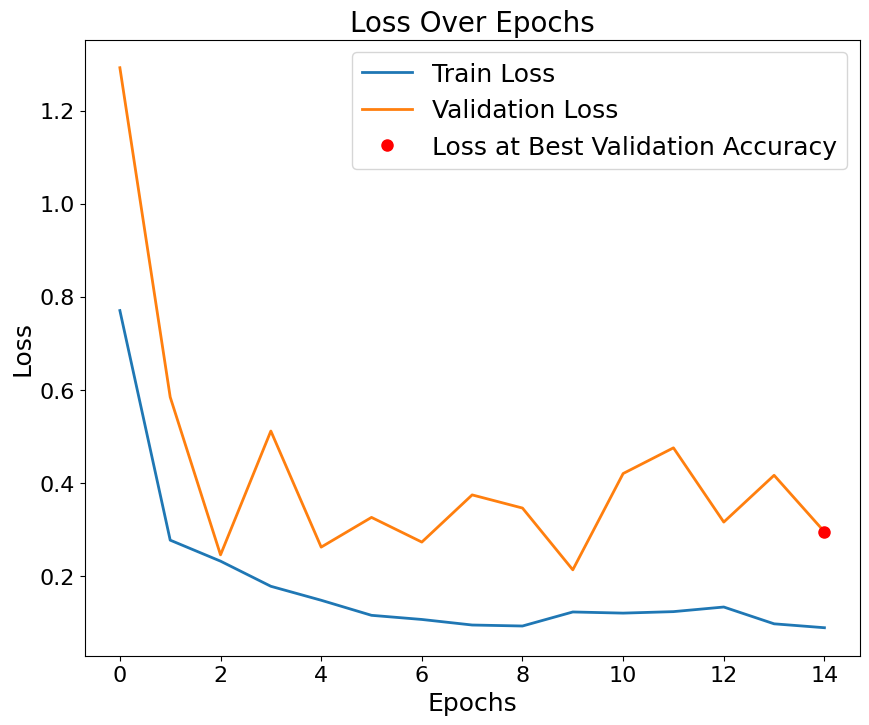

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [47]:
learning_rate = 0.01
name = f'learning_rate_{learning_rate}'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

learning rate 0.001

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

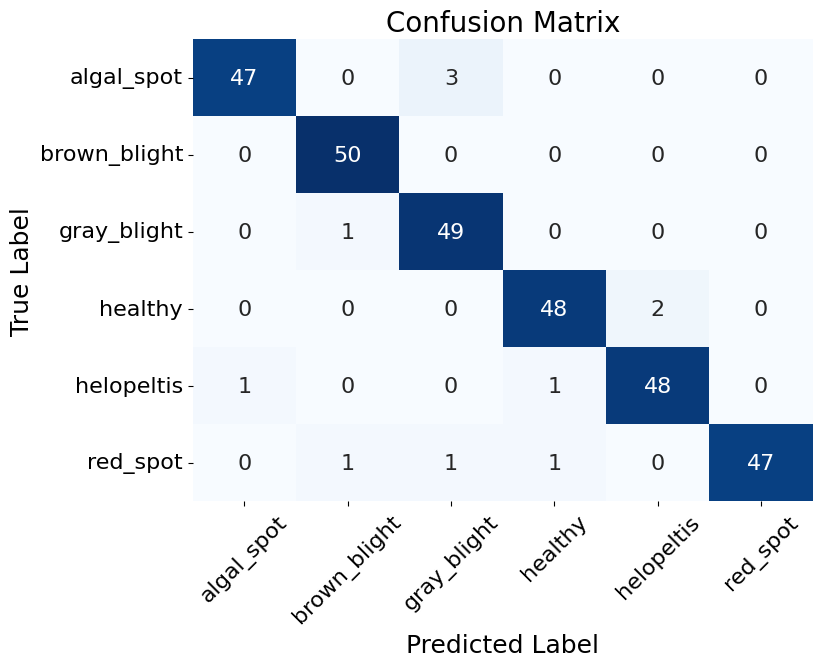

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9792    0.9400    0.9592        50
brown_blight     0.9615    1.0000    0.9804        50
 gray_blight     0.9245    0.9800    0.9515        50
     healthy     0.9600    0.9600    0.9600        50
  helopeltis     0.9600    0.9600    0.9600        50
    red_spot     1.0000    0.9400    0.9691        50

    accuracy                         0.9633       300
   macro avg     0.9642    0.9633    0.9634       300
weighted avg     0.9642    0.9633    0.9634       300

Accuracy: 0.9633
ROC AUC Score: 0.9959


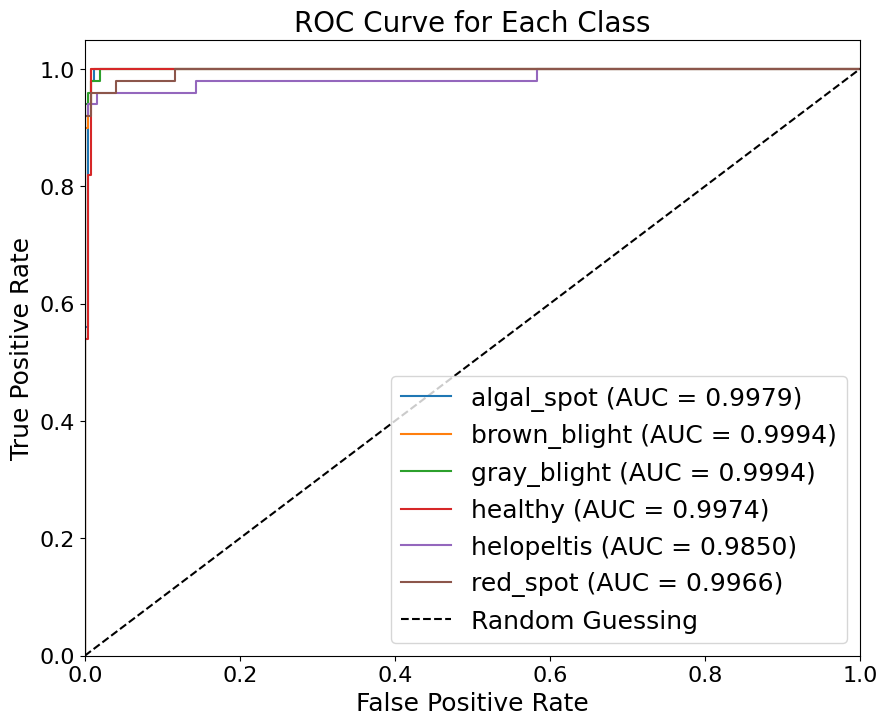

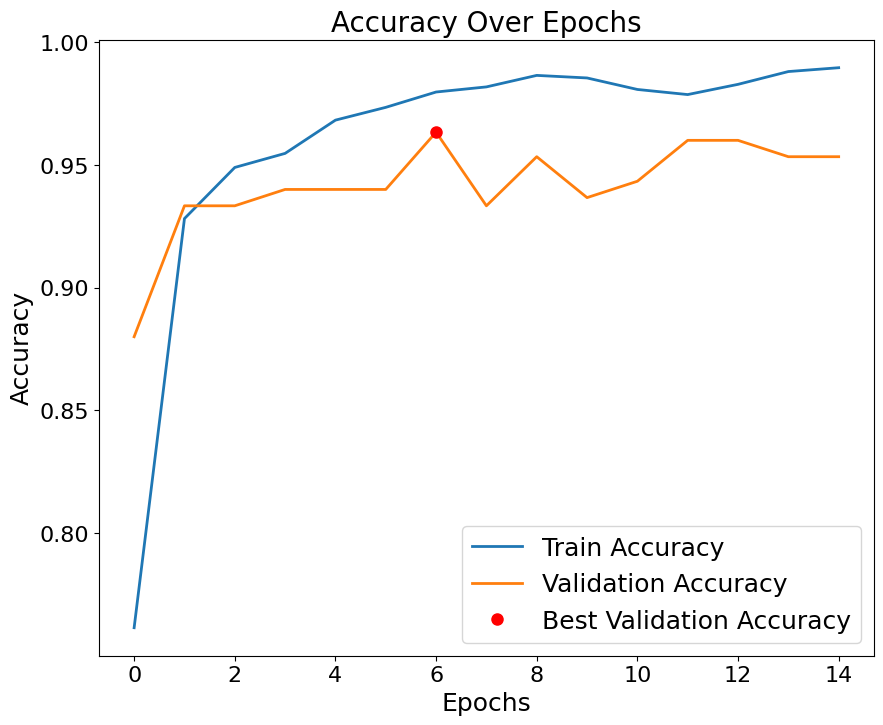

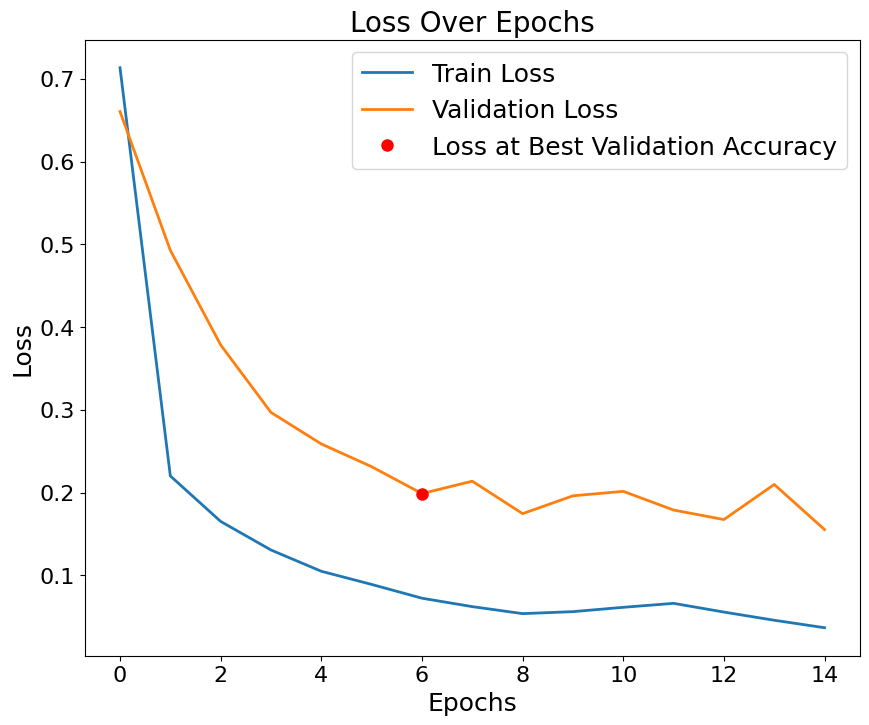

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [55]:
learning_rate = 0.001
name = f'learning_rate_{learning_rate}'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

learning rate 0.0001

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

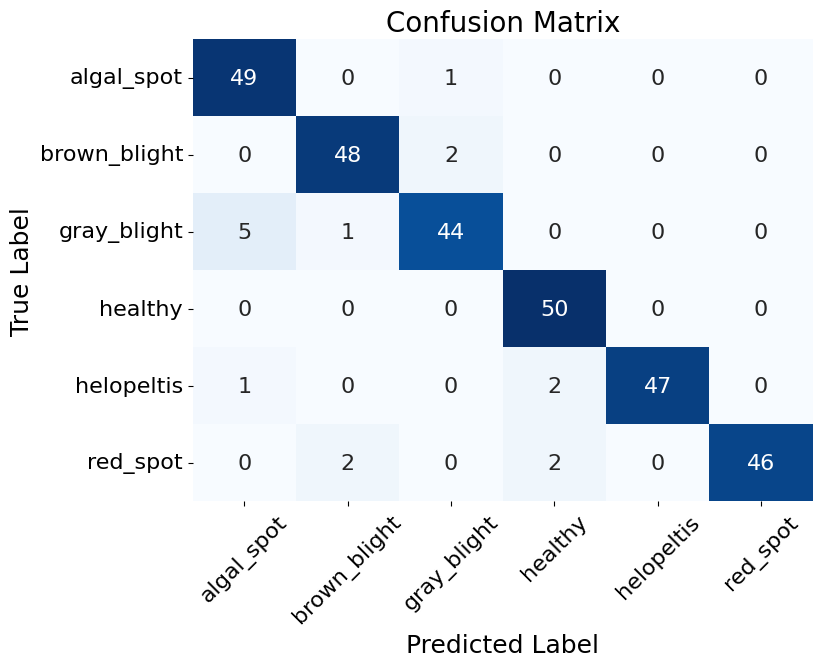

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.8909    0.9800    0.9333        50
brown_blight     0.9412    0.9600    0.9505        50
 gray_blight     0.9362    0.8800    0.9072        50
     healthy     0.9259    1.0000    0.9615        50
  helopeltis     1.0000    0.9400    0.9691        50
    red_spot     1.0000    0.9200    0.9583        50

    accuracy                         0.9467       300
   macro avg     0.9490    0.9467    0.9467       300
weighted avg     0.9490    0.9467    0.9467       300

Accuracy: 0.9467
ROC AUC Score: 0.9940


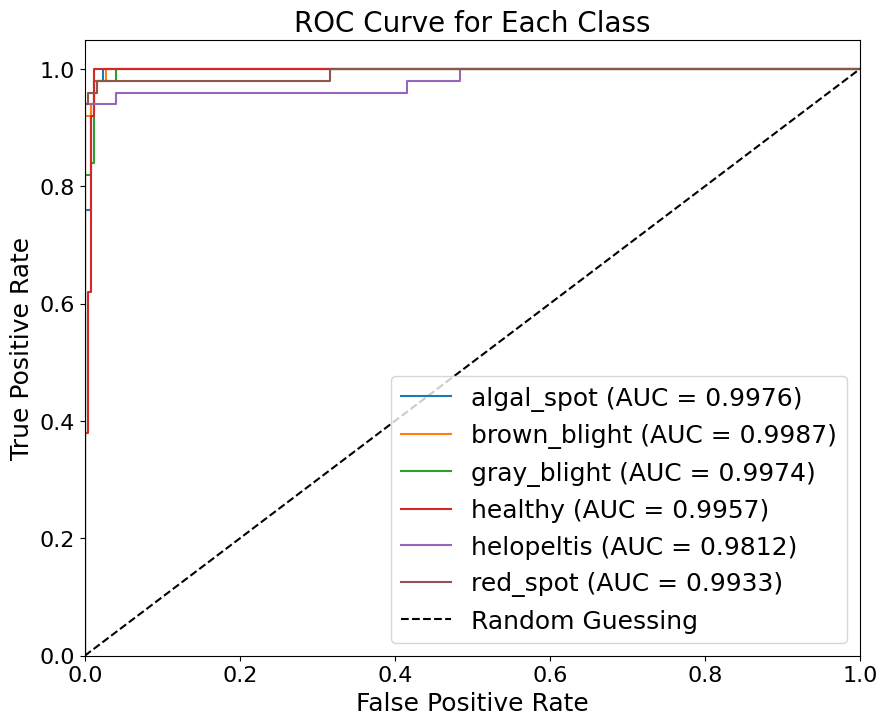

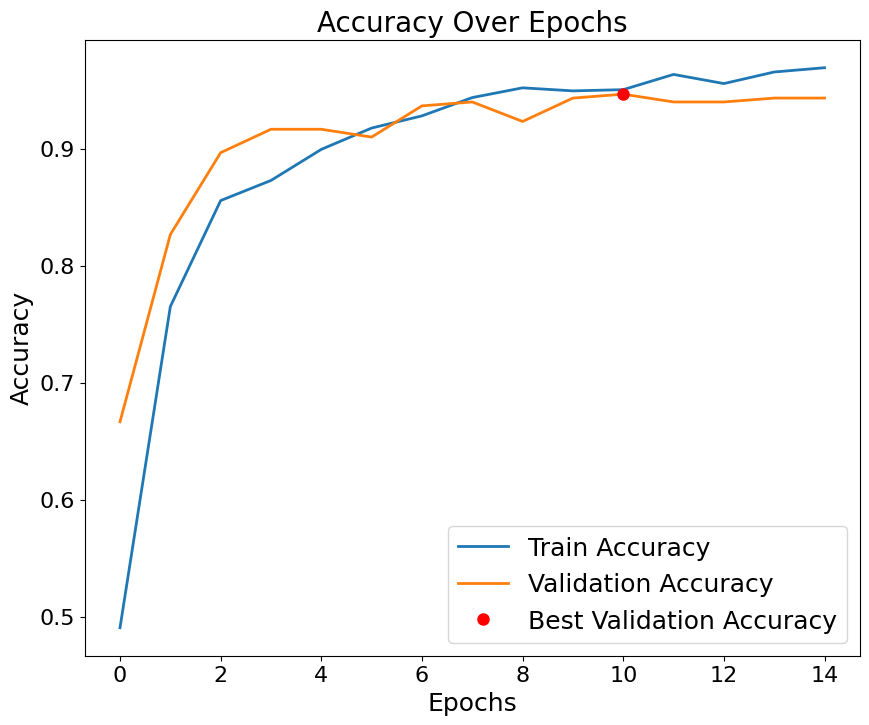

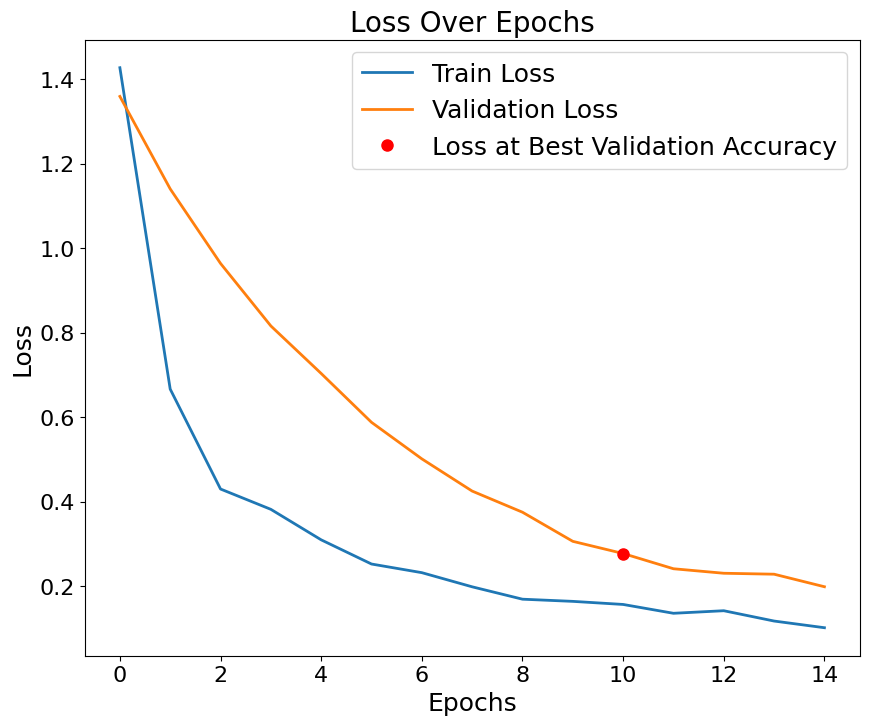

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [57]:
learning_rate = 0.0001
name = f'learning_rate_{learning_rate}'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

**EPOCH**

In [14]:
learning_rate = 0.001

In [ ]:
dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

epoch 15

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

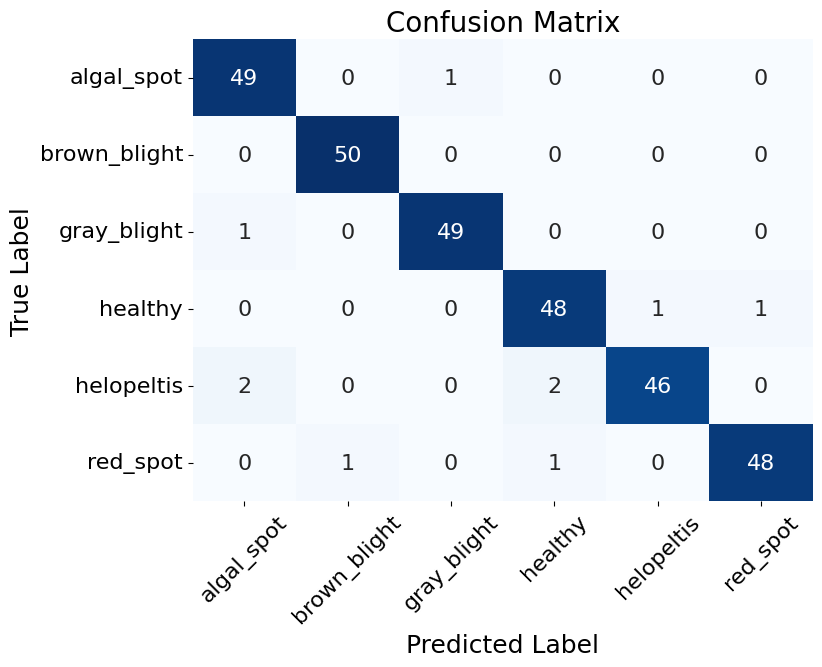

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9423    0.9800    0.9608        50
brown_blight     0.9804    1.0000    0.9901        50
 gray_blight     0.9800    0.9800    0.9800        50
     healthy     0.9412    0.9600    0.9505        50
  helopeltis     0.9787    0.9200    0.9485        50
    red_spot     0.9796    0.9600    0.9697        50

    accuracy                         0.9667       300
   macro avg     0.9670    0.9667    0.9666       300
weighted avg     0.9670    0.9667    0.9666       300

Accuracy: 0.9667
ROC AUC Score: 0.9963


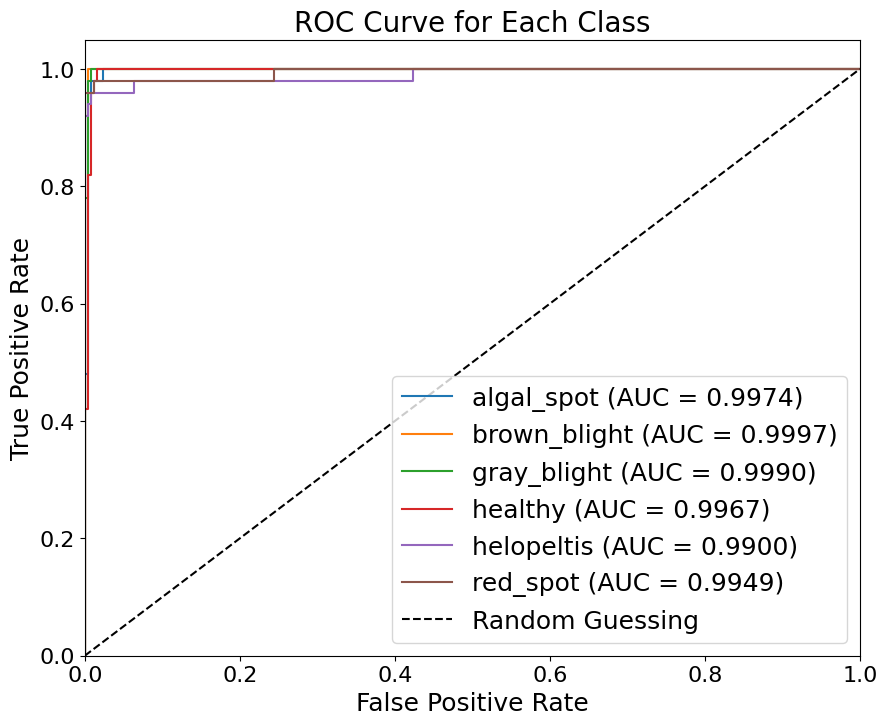

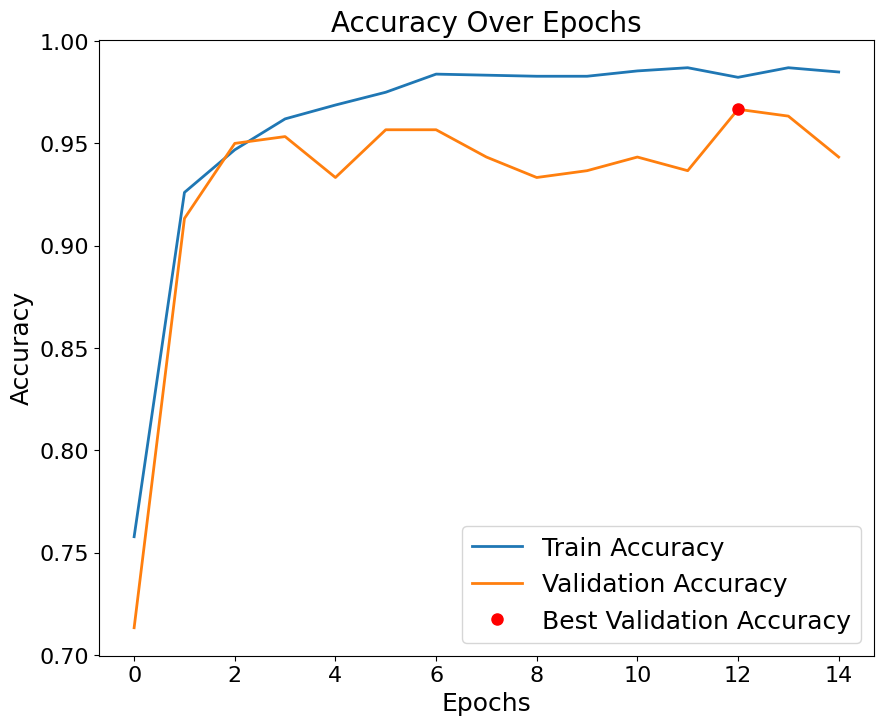

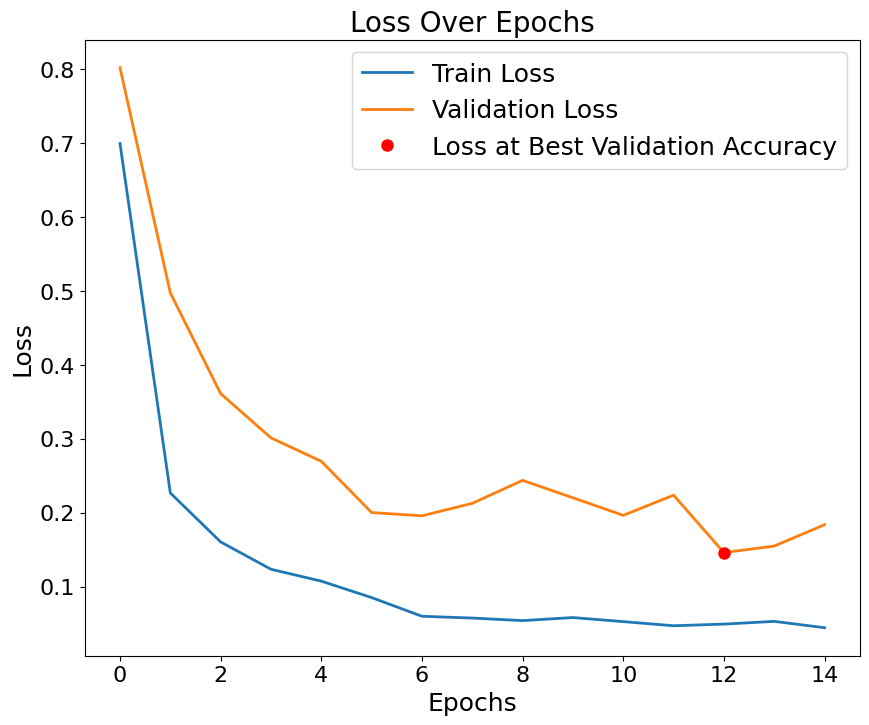

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [60]:
epochs = 15
name = f'epoch_{epochs}'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

epoch 25

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

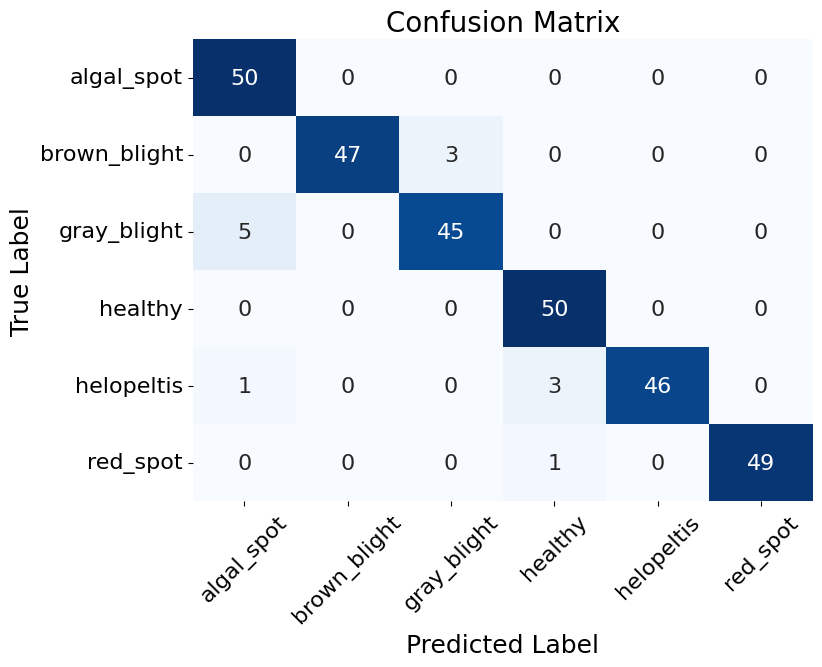

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.8929    1.0000    0.9434        50
brown_blight     1.0000    0.9400    0.9691        50
 gray_blight     0.9375    0.9000    0.9184        50
     healthy     0.9259    1.0000    0.9615        50
  helopeltis     1.0000    0.9200    0.9583        50
    red_spot     1.0000    0.9800    0.9899        50

    accuracy                         0.9567       300
   macro avg     0.9594    0.9567    0.9568       300
weighted avg     0.9594    0.9567    0.9568       300

Accuracy: 0.9567
ROC AUC Score: 0.9951


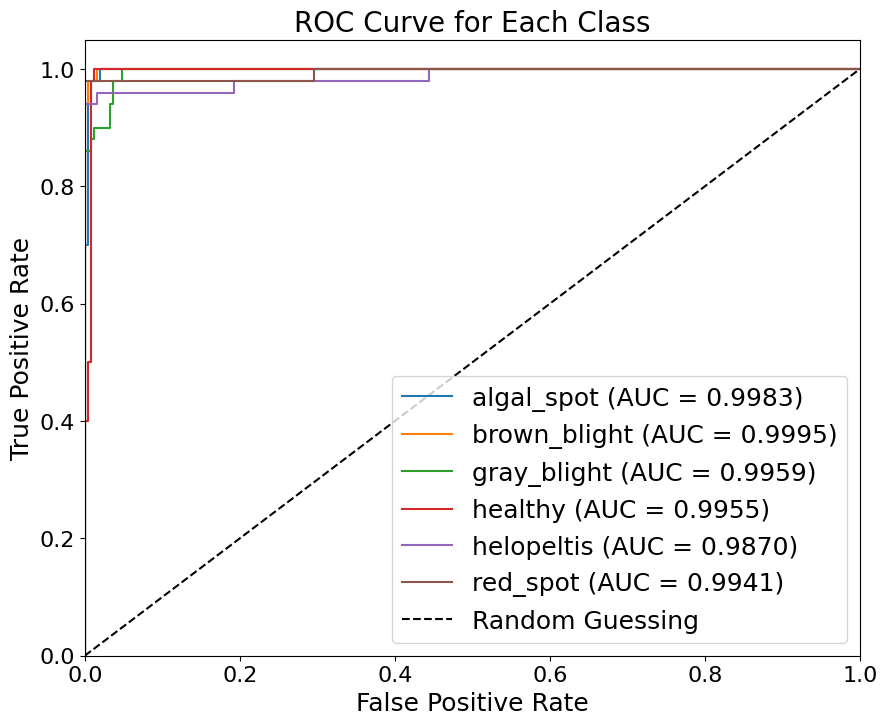

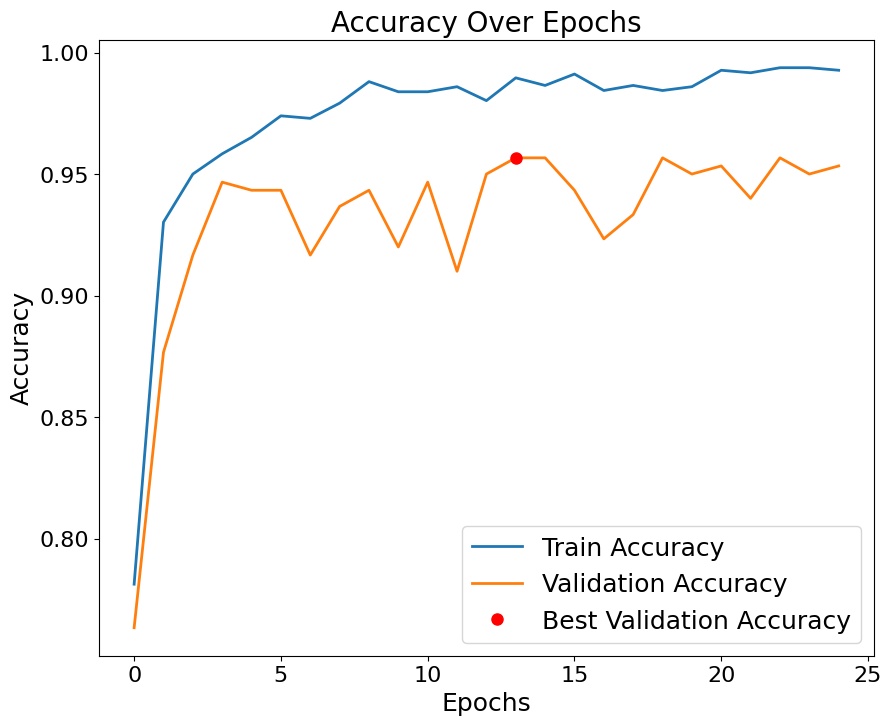

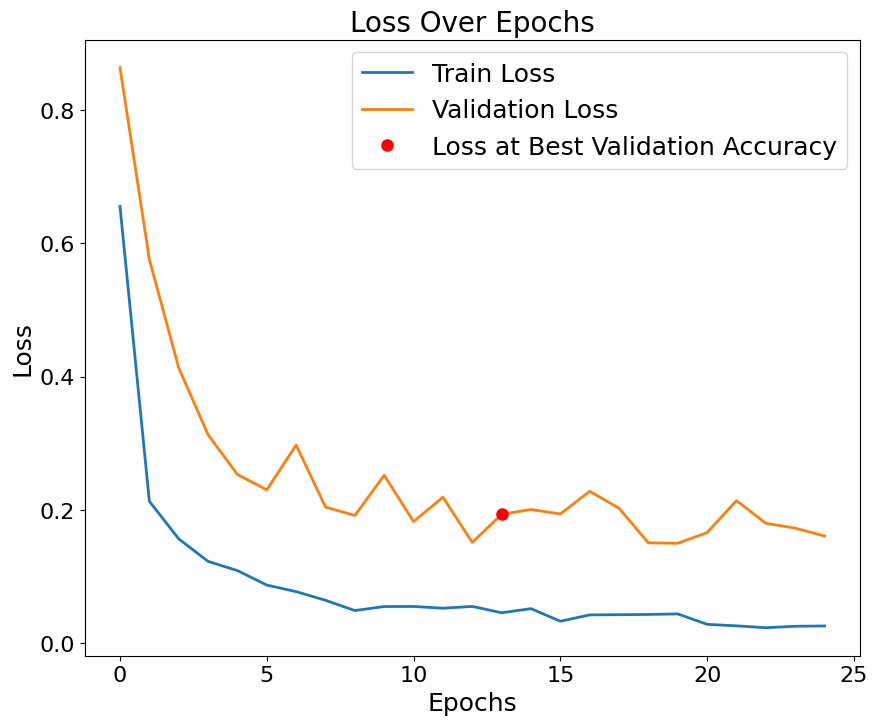

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [18]:
epochs = 25
name = f'epoch_{epochs}_a'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

epoch 35

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

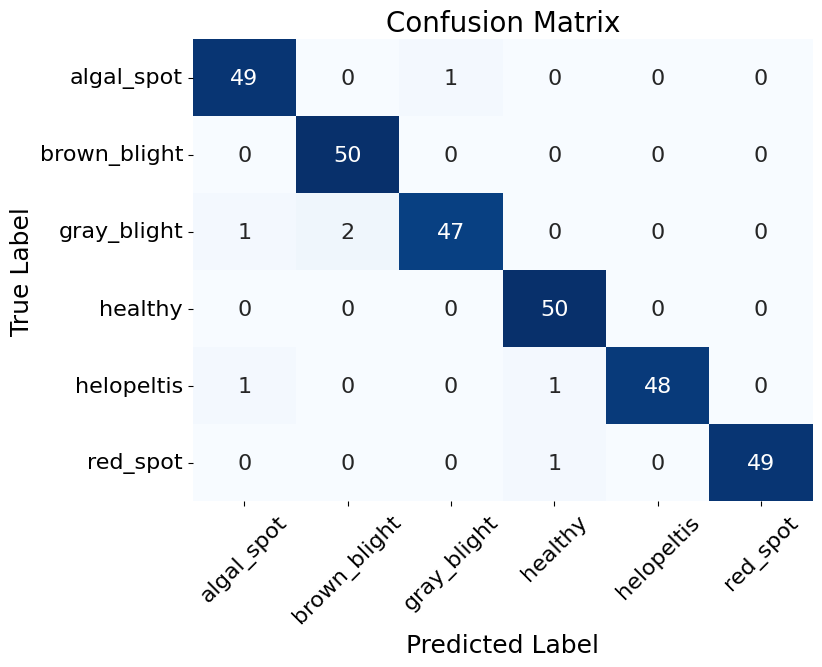

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9608    0.9800    0.9703        50
brown_blight     0.9615    1.0000    0.9804        50
 gray_blight     0.9792    0.9400    0.9592        50
     healthy     0.9615    1.0000    0.9804        50
  helopeltis     1.0000    0.9600    0.9796        50
    red_spot     1.0000    0.9800    0.9899        50

    accuracy                         0.9767       300
   macro avg     0.9772    0.9767    0.9766       300
weighted avg     0.9772    0.9767    0.9766       300

Accuracy: 0.9767
ROC AUC Score: 0.9963


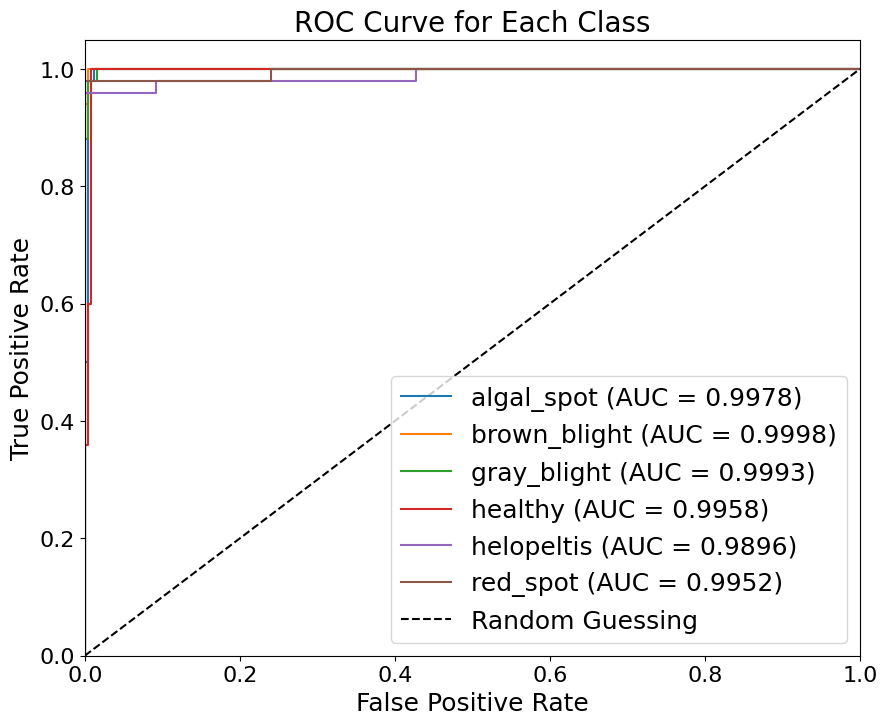

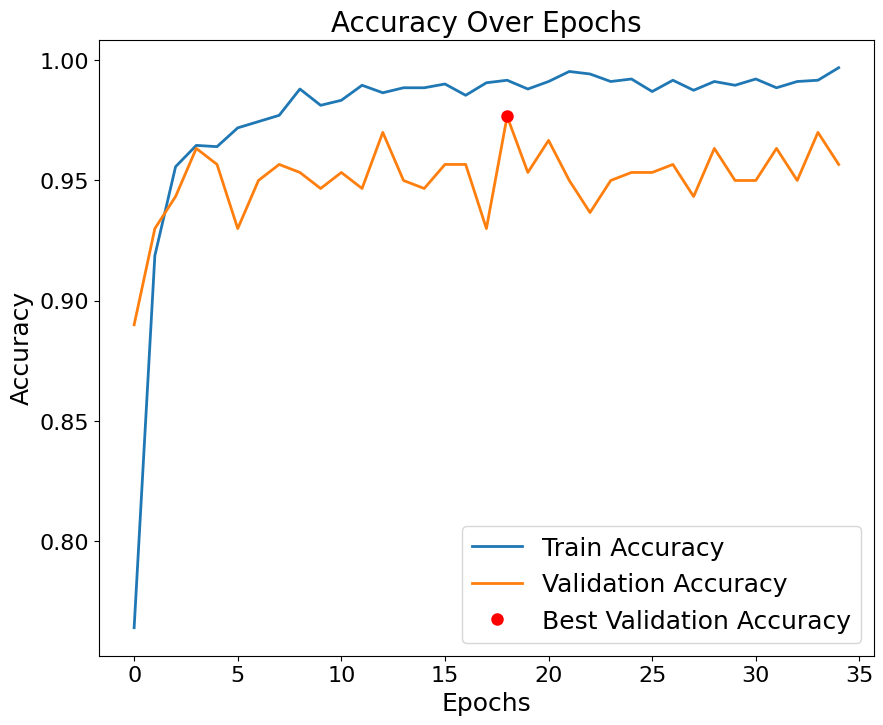

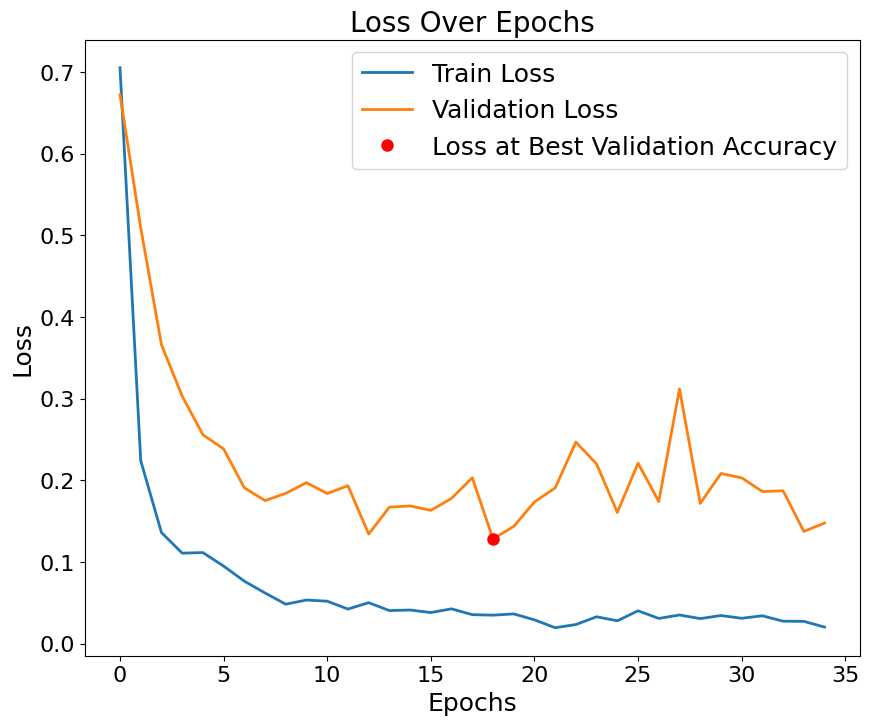

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [64]:
epochs = 35
name = f'epoch_{epochs}'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

epoch 50

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

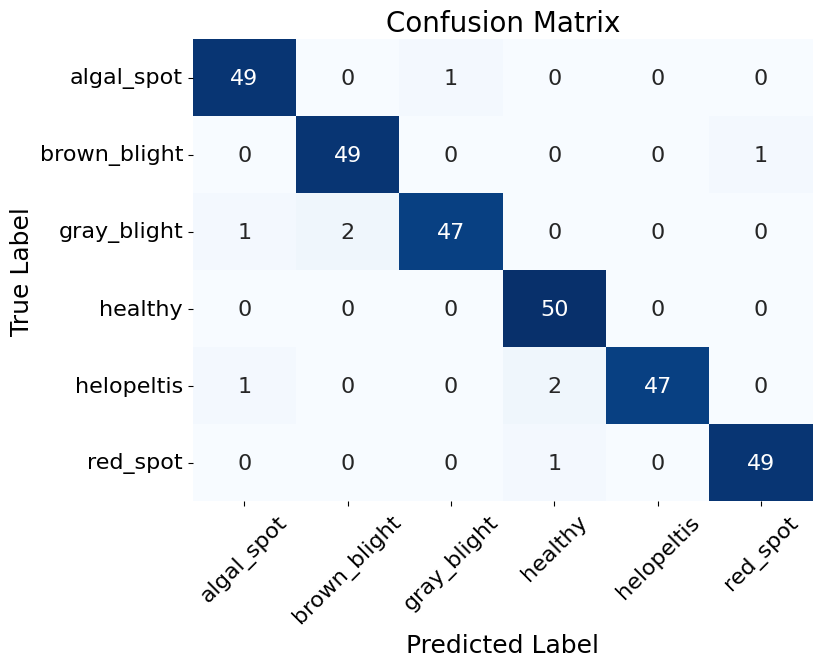

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9608    0.9800    0.9703        50
brown_blight     0.9608    0.9800    0.9703        50
 gray_blight     0.9792    0.9400    0.9592        50
     healthy     0.9434    1.0000    0.9709        50
  helopeltis     1.0000    0.9400    0.9691        50
    red_spot     0.9800    0.9800    0.9800        50

    accuracy                         0.9700       300
   macro avg     0.9707    0.9700    0.9700       300
weighted avg     0.9707    0.9700    0.9700       300

Accuracy: 0.9700
ROC AUC Score: 0.9972


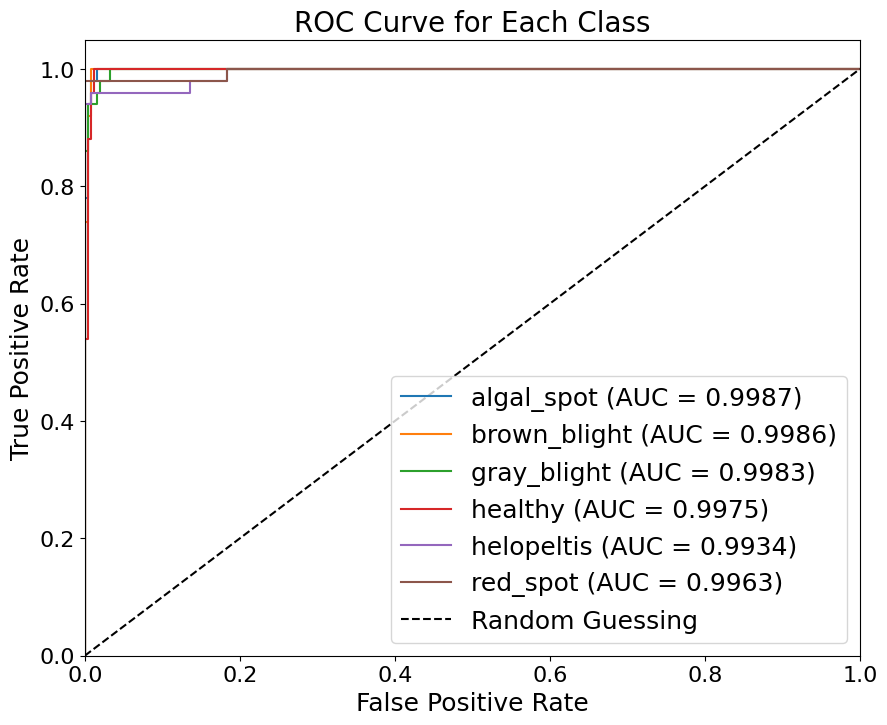

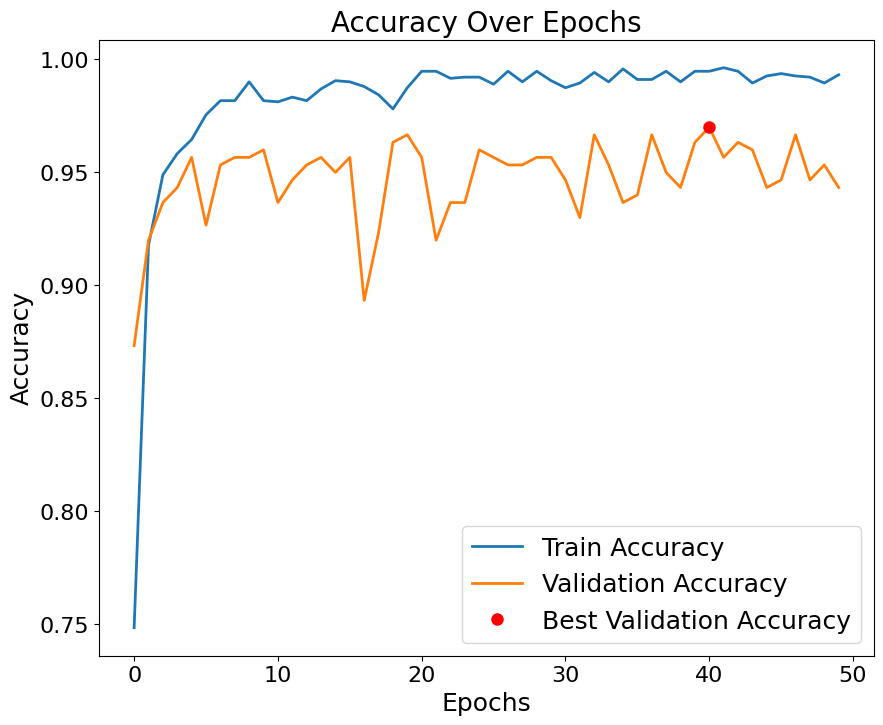

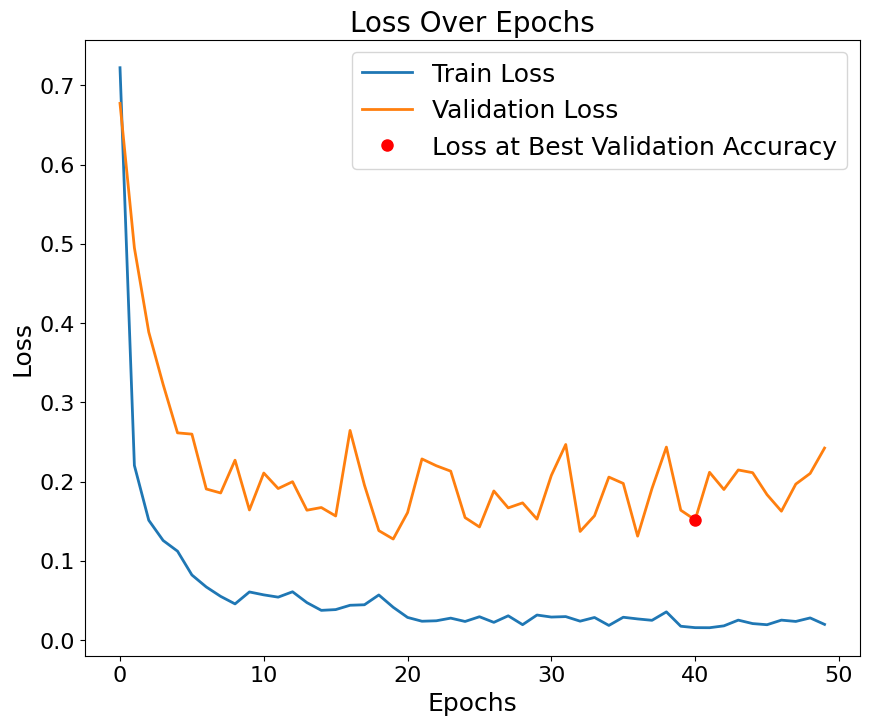

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [66]:
epochs = 50
name = f'epoch_{epochs}'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

**6. BATCH SIZE**

In [27]:
epochs = 35

batch size 32

Found 5867 files belonging to 6 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
             

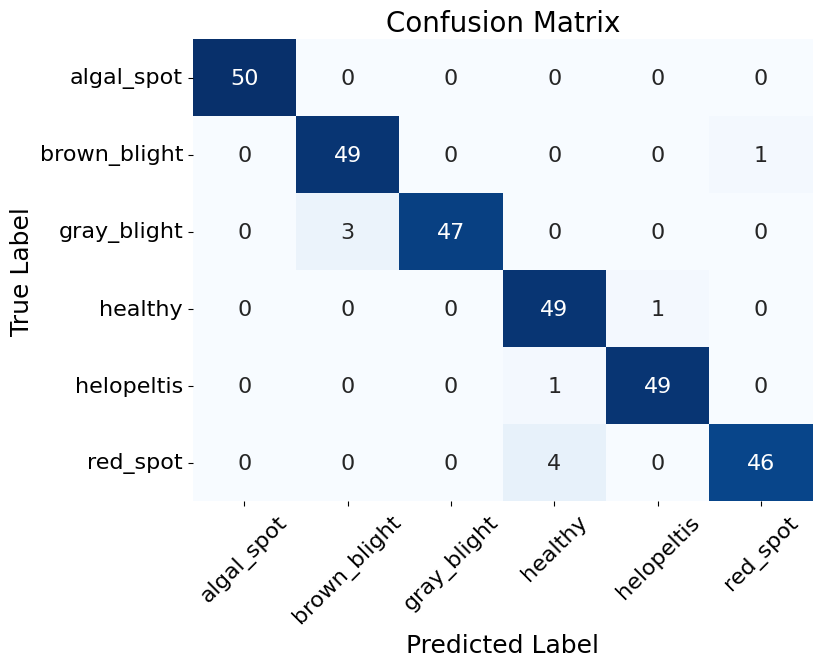

Classification Report:
              precision    recall  f1-score   support

  algal_spot     1.0000    1.0000    1.0000        50
brown_blight     0.9423    0.9800    0.9608        50
 gray_blight     1.0000    0.9400    0.9691        50
     healthy     0.9074    0.9800    0.9423        50
  helopeltis     0.9800    0.9800    0.9800        50
    red_spot     0.9787    0.9200    0.9485        50

    accuracy                         0.9667       300
   macro avg     0.9681    0.9667    0.9668       300
weighted avg     0.9681    0.9667    0.9668       300

Accuracy: 0.9667
ROC AUC Score: 0.9990


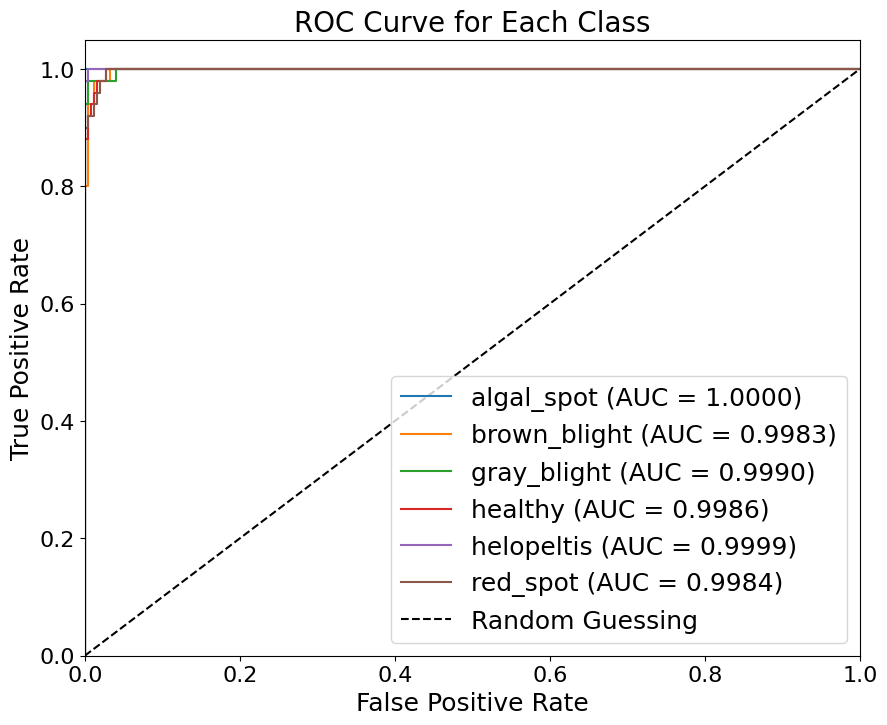

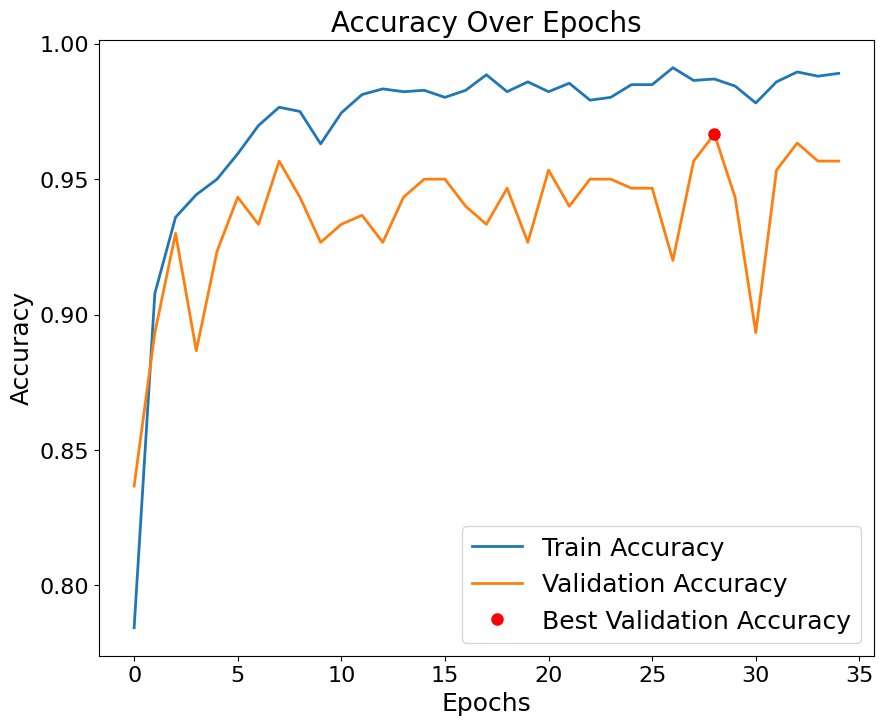

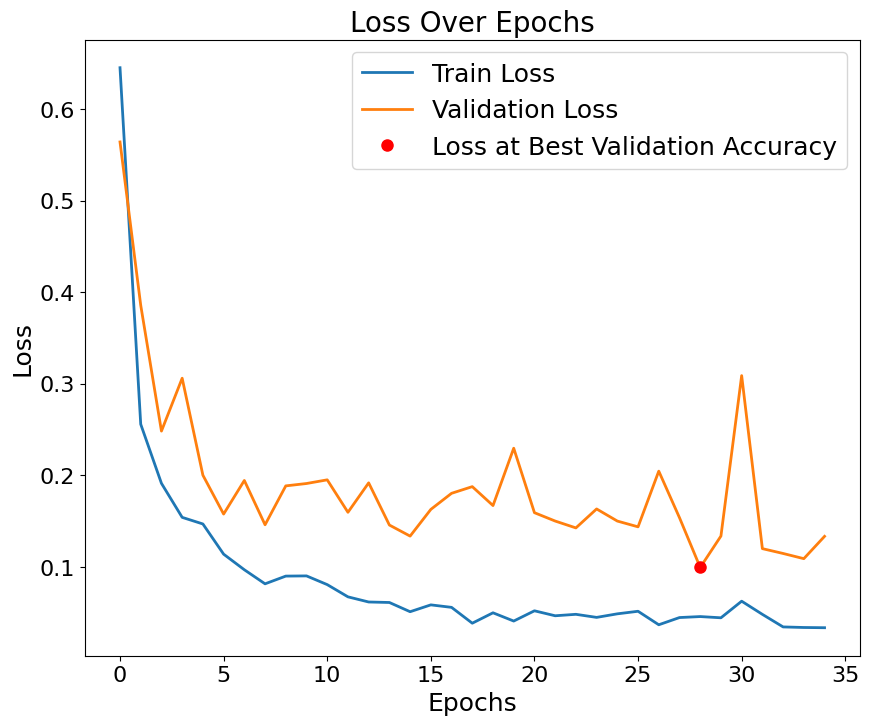

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [18]:
batch_size = 32
name = f'batch_size_{batch_size}'

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

batch size 64

Found 5867 files belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
               

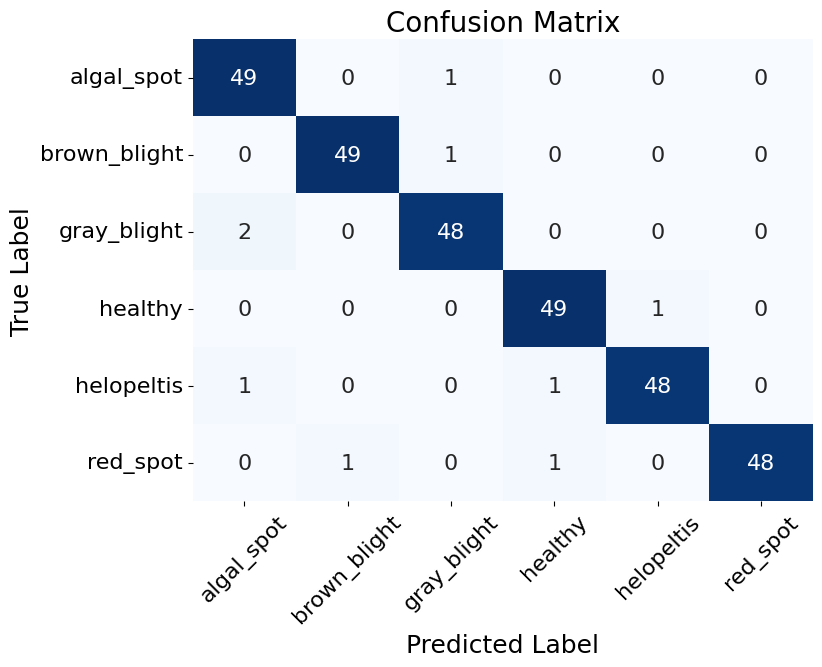

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9423    0.9800    0.9608        50
brown_blight     0.9800    0.9800    0.9800        50
 gray_blight     0.9600    0.9600    0.9600        50
     healthy     0.9608    0.9800    0.9703        50
  helopeltis     0.9796    0.9600    0.9697        50
    red_spot     1.0000    0.9600    0.9796        50

    accuracy                         0.9700       300
   macro avg     0.9704    0.9700    0.9701       300
weighted avg     0.9704    0.9700    0.9701       300

Accuracy: 0.9700
ROC AUC Score: 0.9957


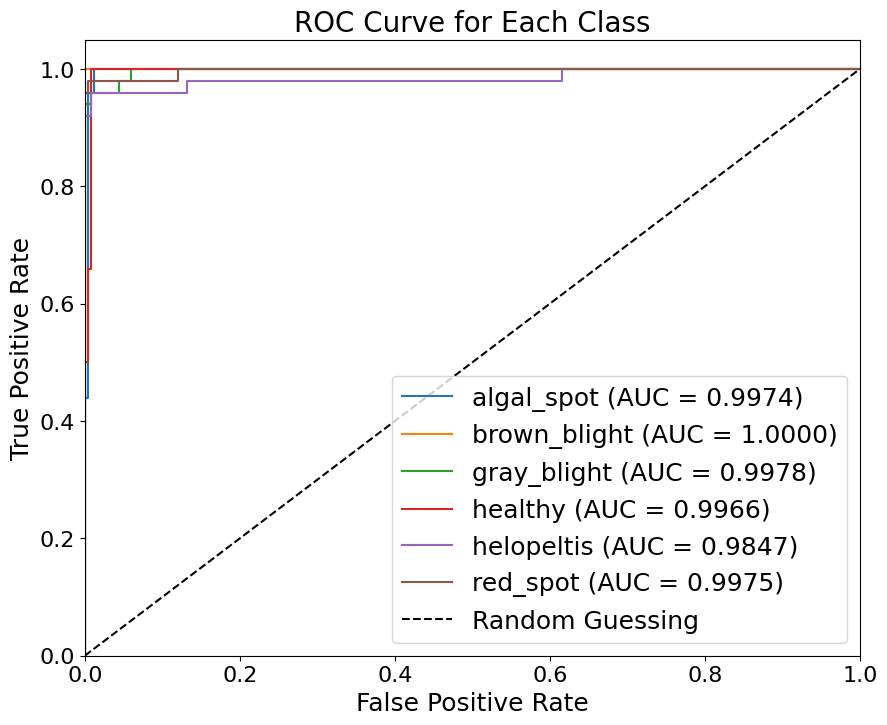

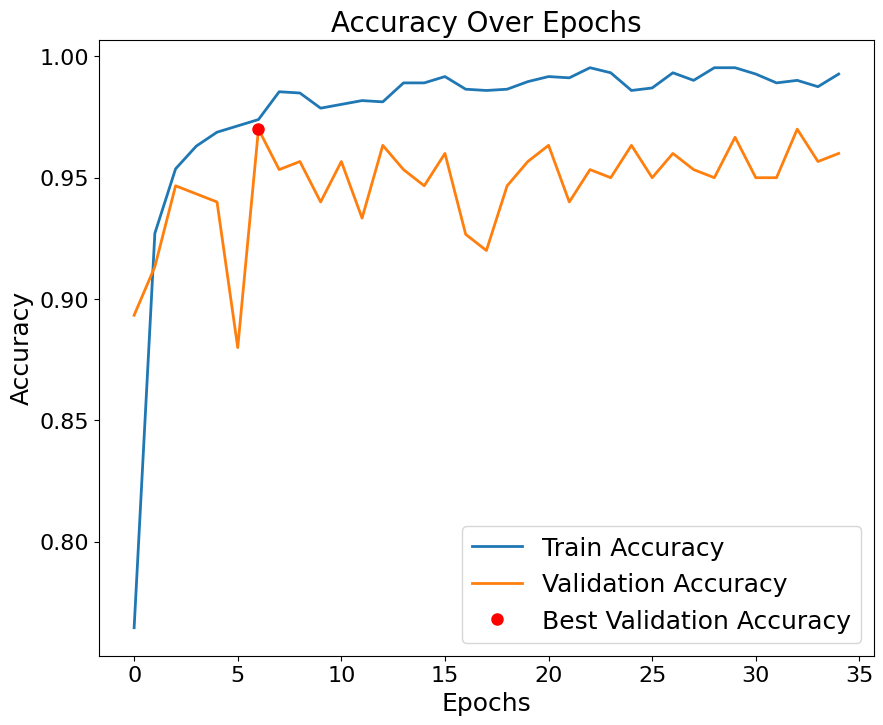

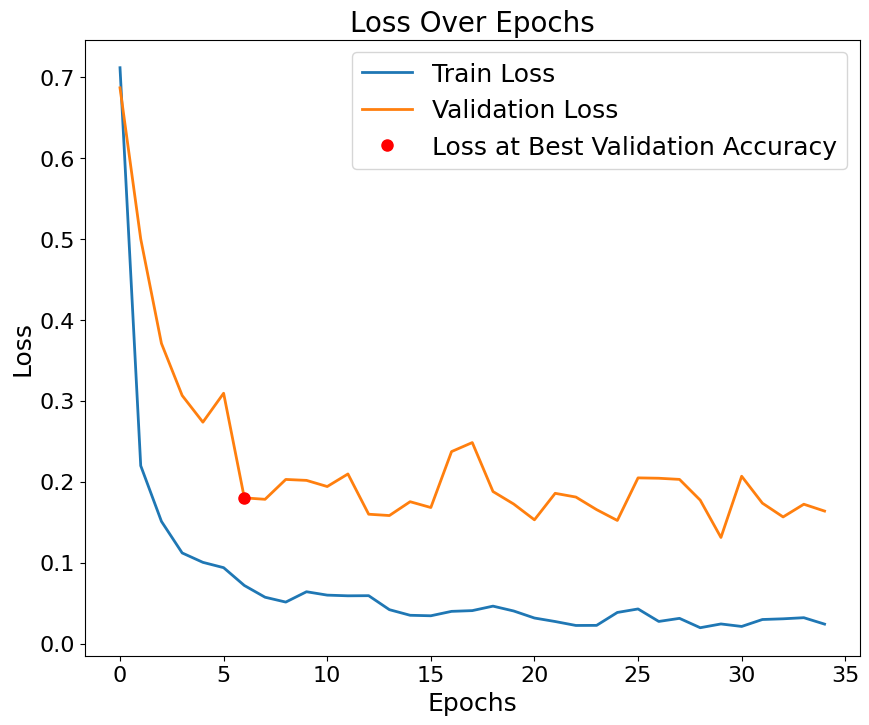

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [30]:
batch_size = 64
name = f'batch_size_{batch_size}_a'

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

batch size 128

Found 5867 files belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
               

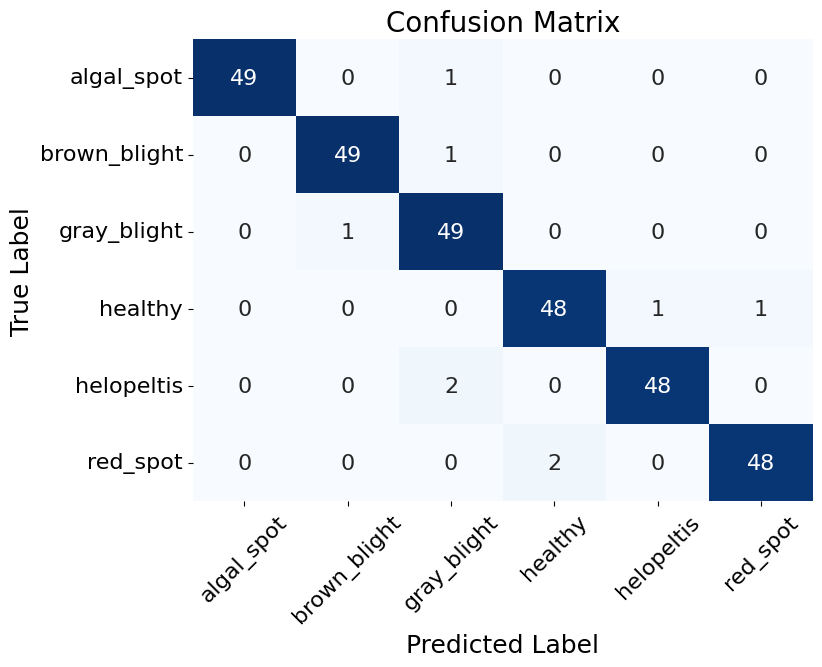

Classification Report:
              precision    recall  f1-score   support

  algal_spot     1.0000    0.9800    0.9899        50
brown_blight     0.9800    0.9800    0.9800        50
 gray_blight     0.9245    0.9800    0.9515        50
     healthy     0.9600    0.9600    0.9600        50
  helopeltis     0.9796    0.9600    0.9697        50
    red_spot     0.9796    0.9600    0.9697        50

    accuracy                         0.9700       300
   macro avg     0.9706    0.9700    0.9701       300
weighted avg     0.9706    0.9700    0.9701       300

Accuracy: 0.9700
ROC AUC Score: 0.9957


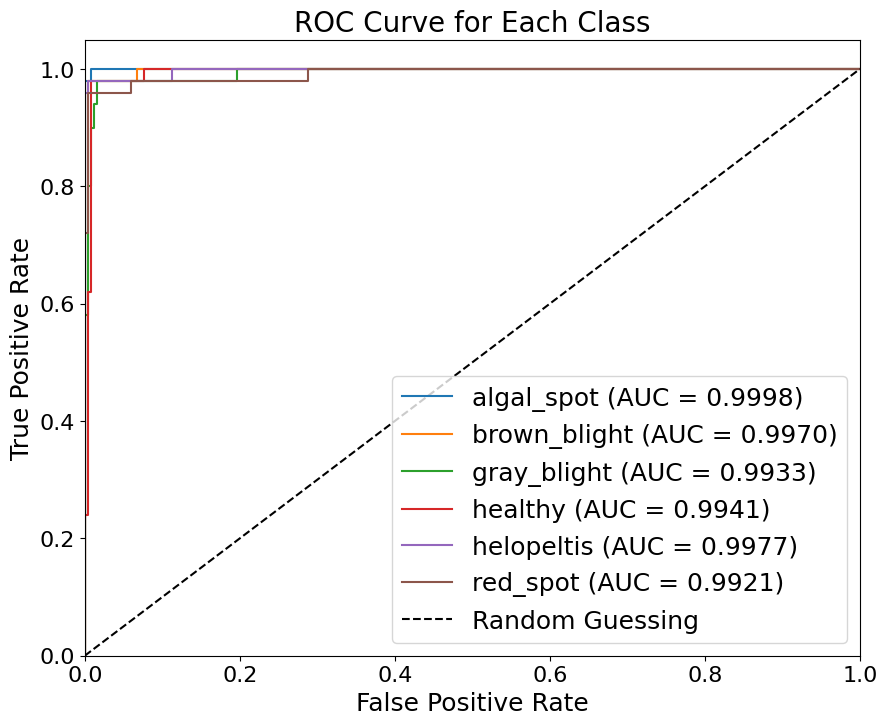

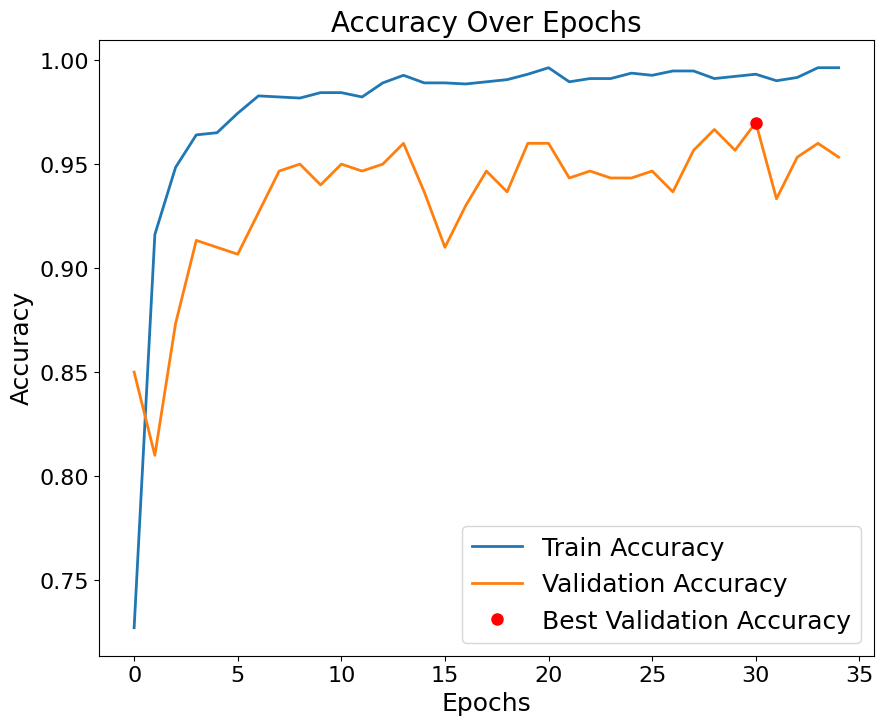

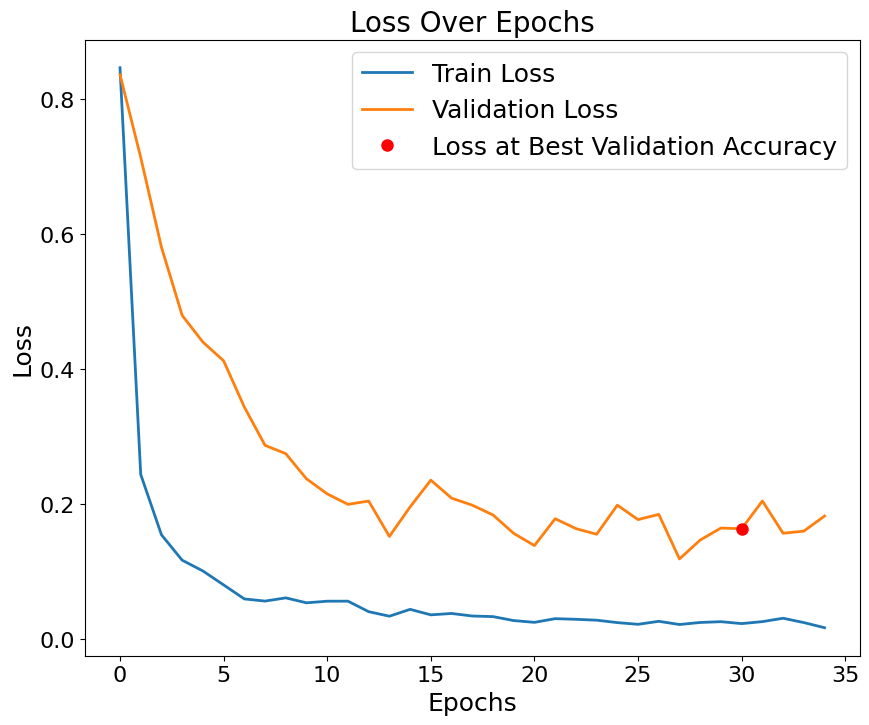

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [24]:
batch_size = 128
name = f'batch_size_{batch_size}'

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

**4. DROPOUT**

In [32]:
batch_size = 64

In [33]:
dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

Found 5867 files belonging to 6 classes.


dropout 0.2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

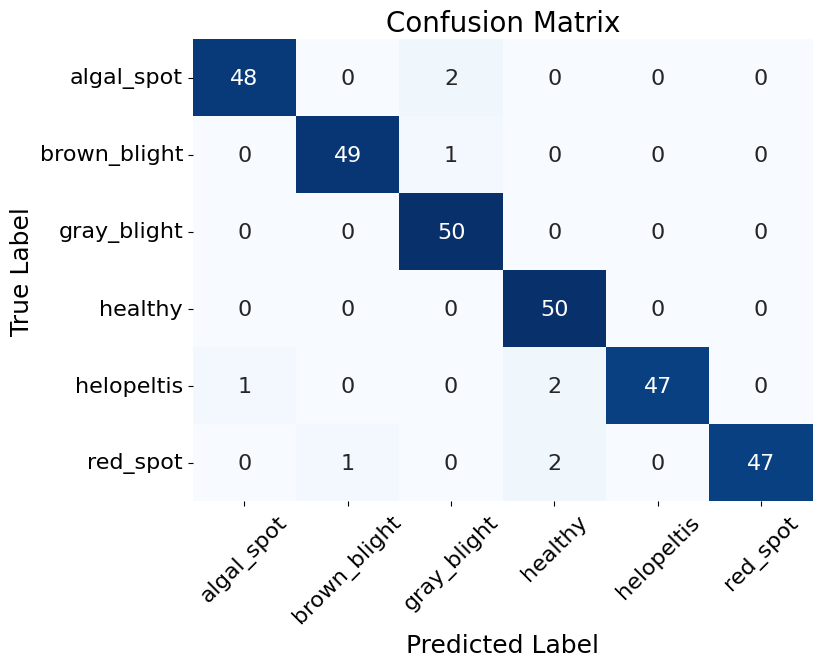

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9796    0.9600    0.9697        50
brown_blight     0.9800    0.9800    0.9800        50
 gray_blight     0.9434    1.0000    0.9709        50
     healthy     0.9259    1.0000    0.9615        50
  helopeltis     1.0000    0.9400    0.9691        50
    red_spot     1.0000    0.9400    0.9691        50

    accuracy                         0.9700       300
   macro avg     0.9715    0.9700    0.9700       300
weighted avg     0.9715    0.9700    0.9700       300

Accuracy: 0.9700
ROC AUC Score: 0.9969


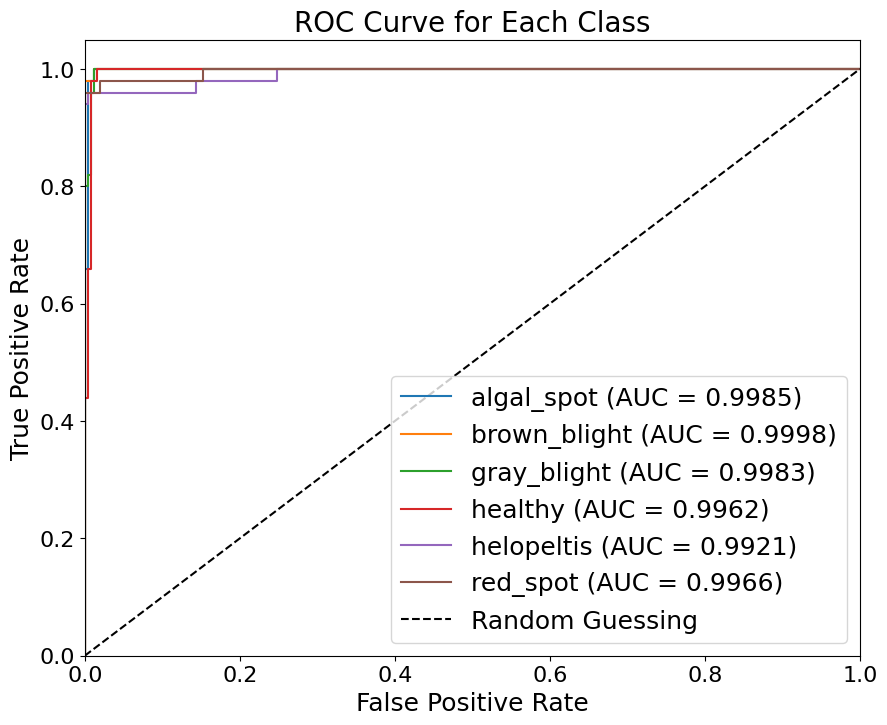

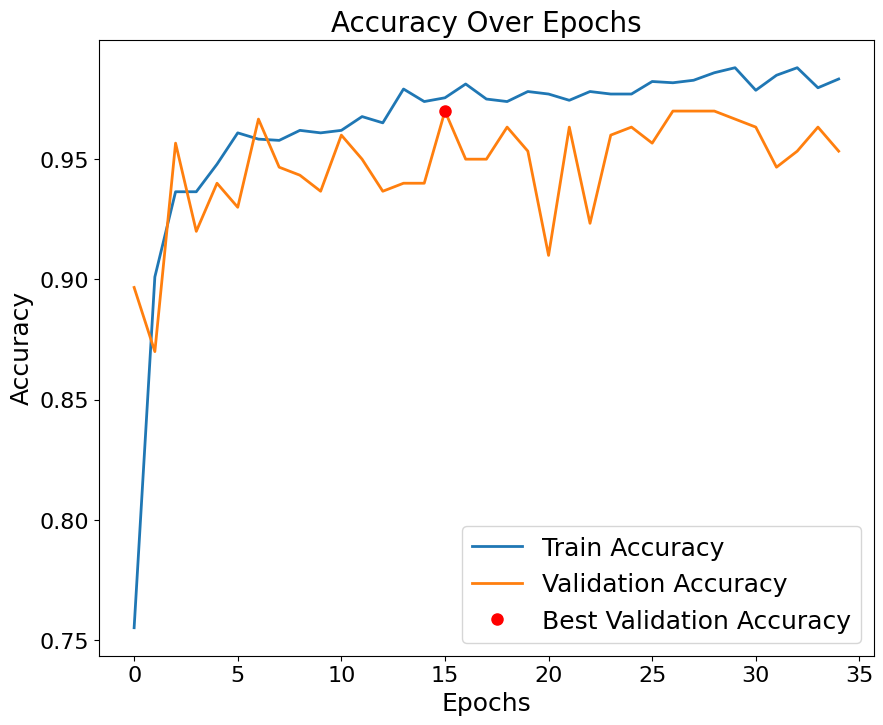

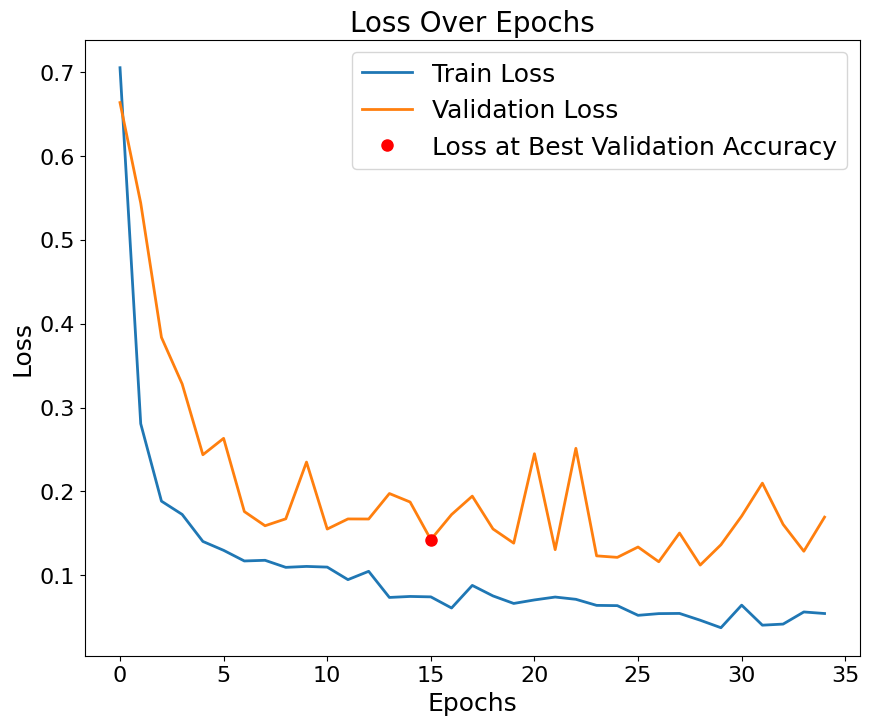

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [18]:
dropout_rate = 0.2
name = f'dropout_rate_{dropout_rate}_a'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

dropout 0.3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

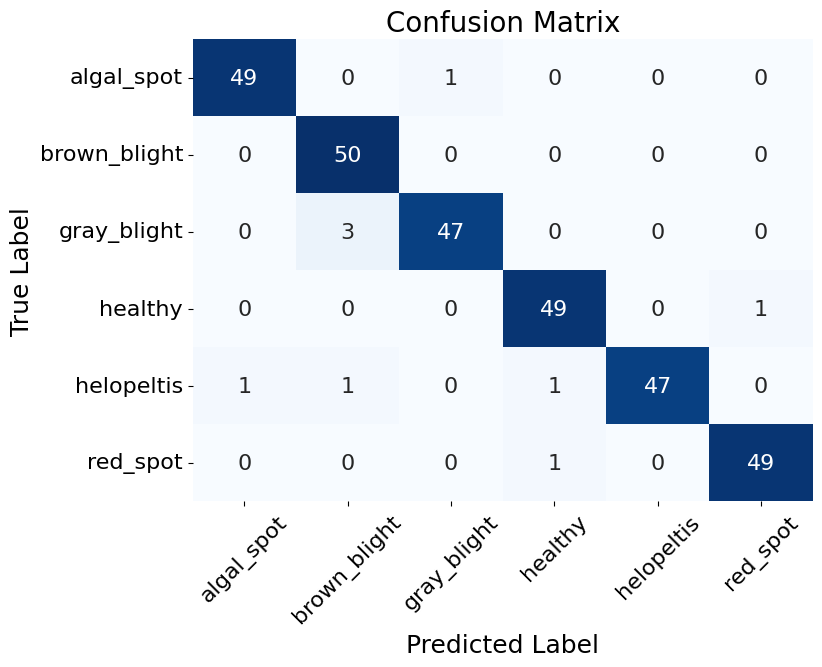

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9800    0.9800    0.9800        50
brown_blight     0.9259    1.0000    0.9615        50
 gray_blight     0.9792    0.9400    0.9592        50
     healthy     0.9608    0.9800    0.9703        50
  helopeltis     1.0000    0.9400    0.9691        50
    red_spot     0.9800    0.9800    0.9800        50

    accuracy                         0.9700       300
   macro avg     0.9710    0.9700    0.9700       300
weighted avg     0.9710    0.9700    0.9700       300

Accuracy: 0.9700
ROC AUC Score: 0.9966


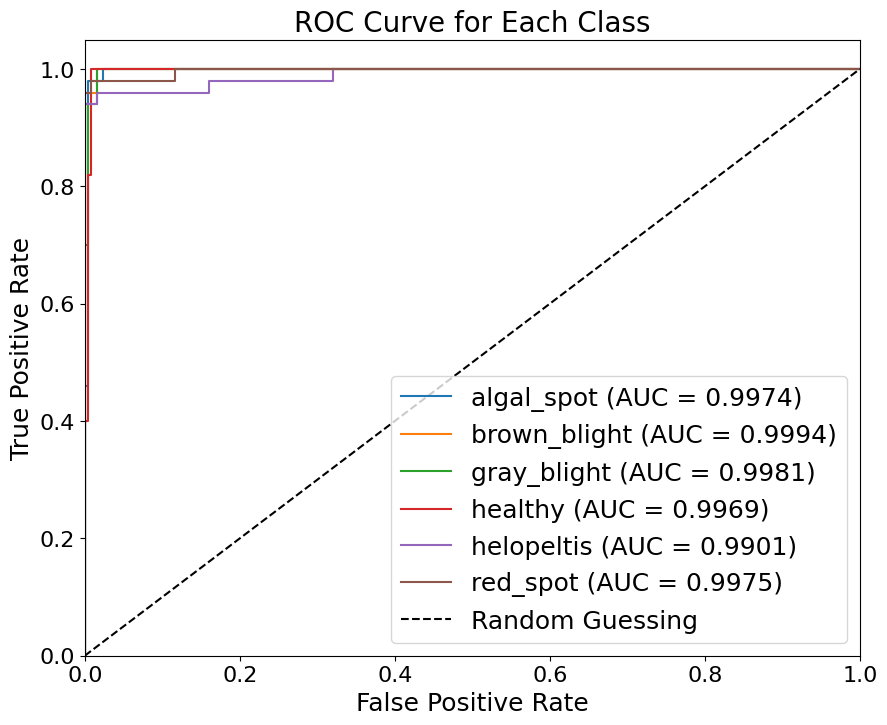

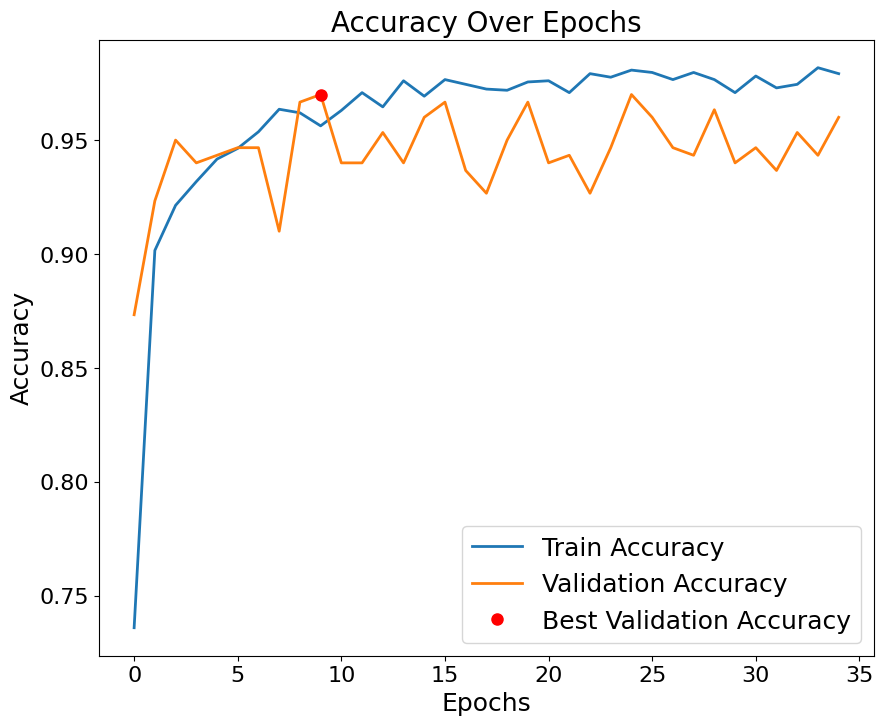

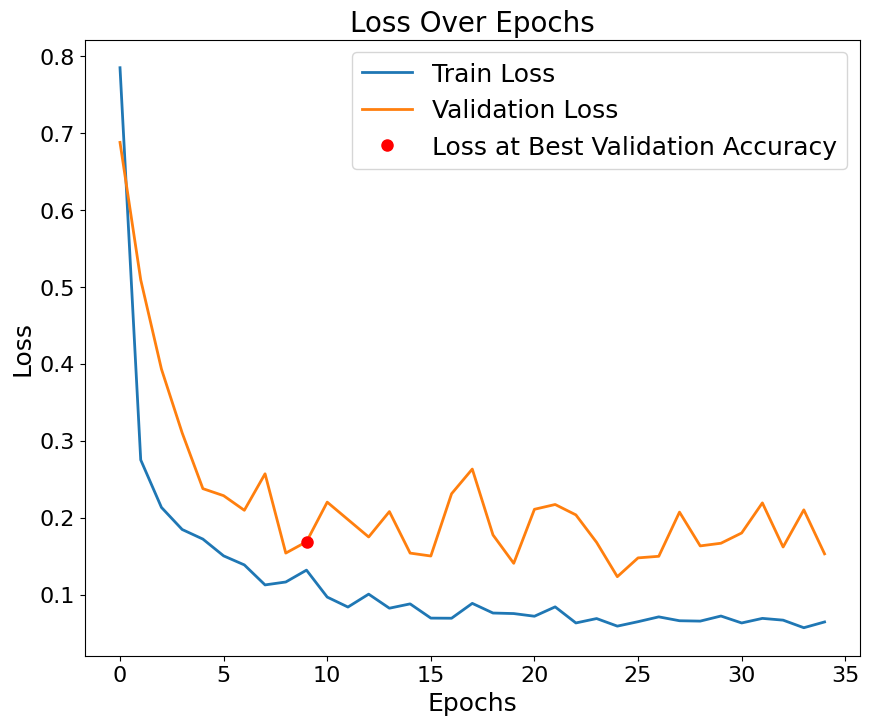

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [20]:
dropout_rate = 0.3
name = f'dropout_rate_{dropout_rate}_a'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

dropout 0.4

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

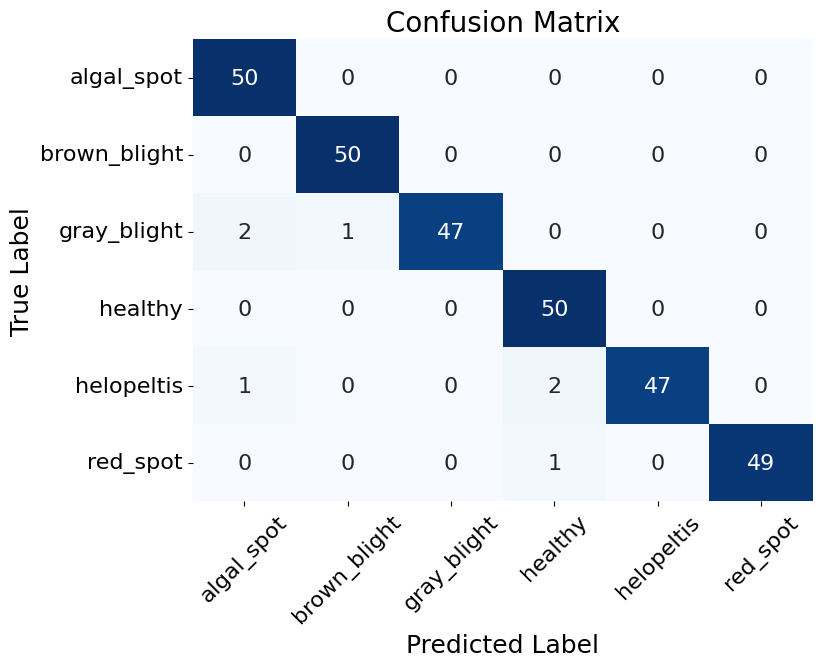

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9434    1.0000    0.9709        50
brown_blight     0.9804    1.0000    0.9901        50
 gray_blight     1.0000    0.9400    0.9691        50
     healthy     0.9434    1.0000    0.9709        50
  helopeltis     1.0000    0.9400    0.9691        50
    red_spot     1.0000    0.9800    0.9899        50

    accuracy                         0.9767       300
   macro avg     0.9779    0.9767    0.9766       300
weighted avg     0.9779    0.9767    0.9766       300

Accuracy: 0.9767
ROC AUC Score: 0.9966


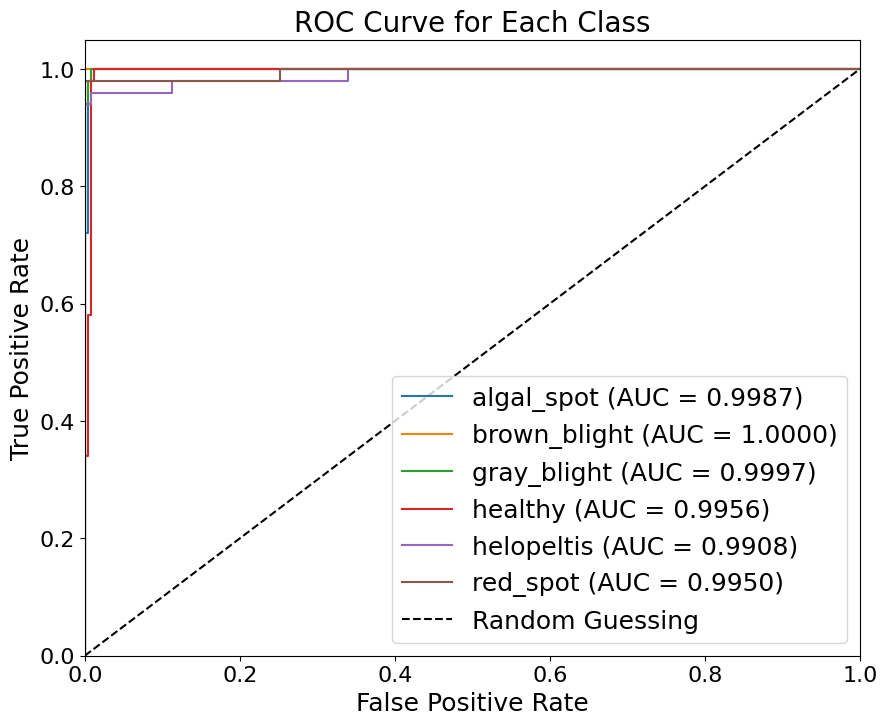

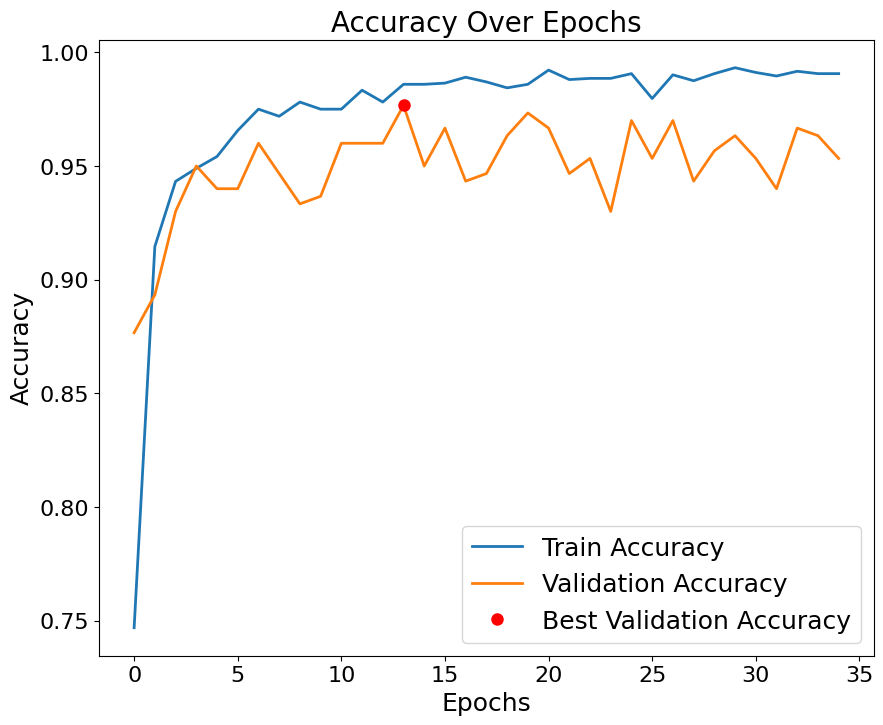

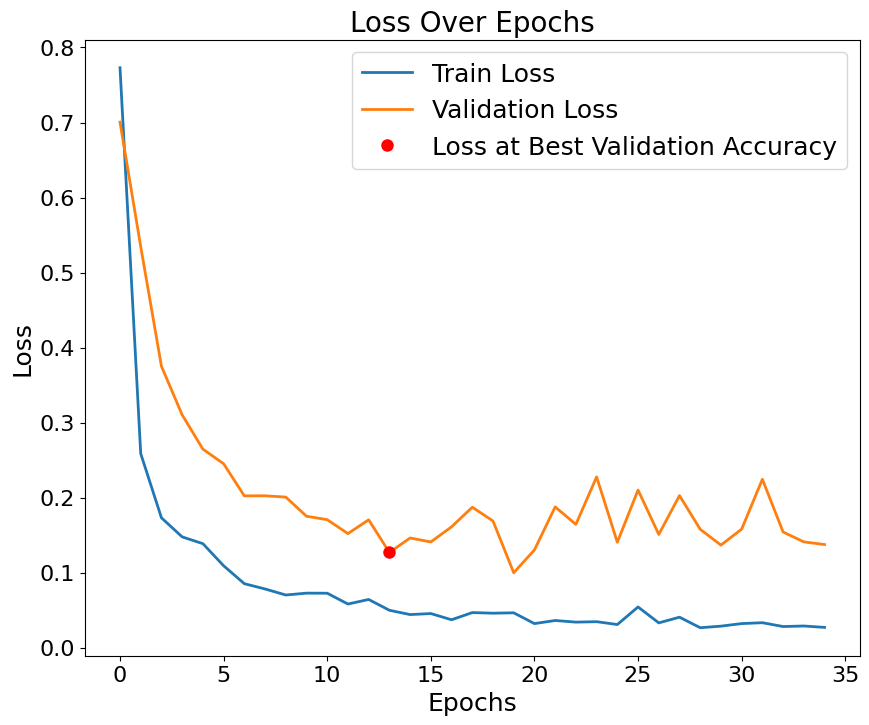

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [37]:
dropout_rate = 0.4
name = f'dropout_rate_{dropout_rate}_a'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

dropout 0.5

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

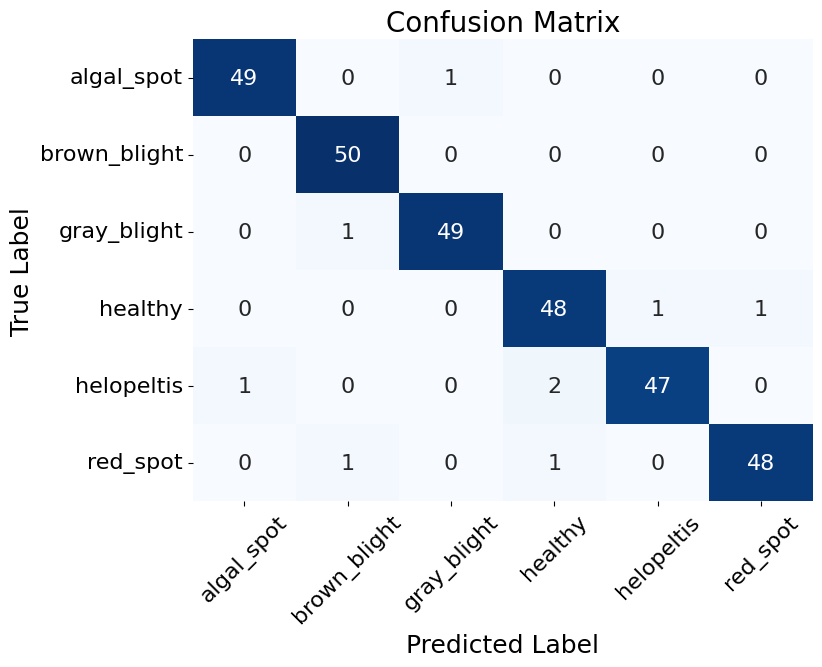

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9800    0.9800    0.9800        50
brown_blight     0.9615    1.0000    0.9804        50
 gray_blight     0.9800    0.9800    0.9800        50
     healthy     0.9412    0.9600    0.9505        50
  helopeltis     0.9792    0.9400    0.9592        50
    red_spot     0.9796    0.9600    0.9697        50

    accuracy                         0.9700       300
   macro avg     0.9702    0.9700    0.9700       300
weighted avg     0.9702    0.9700    0.9700       300

Accuracy: 0.9700
ROC AUC Score: 0.9963


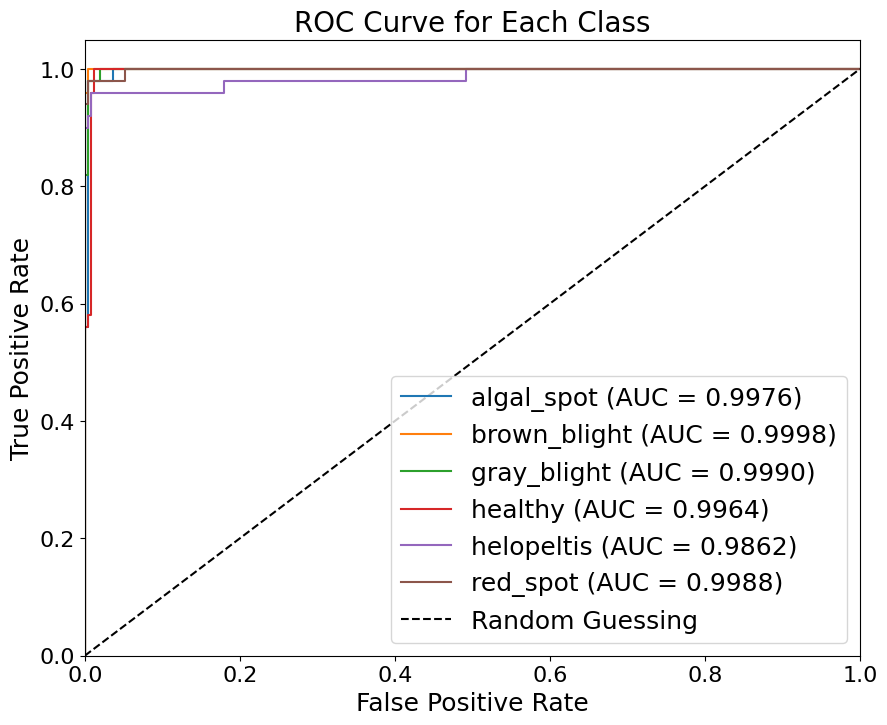

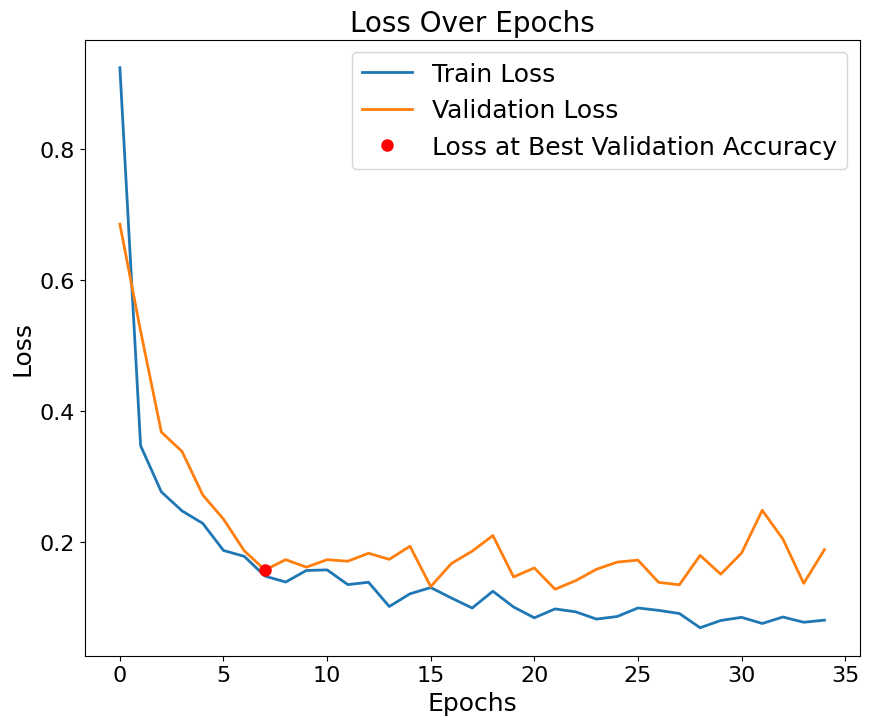

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [16]:
dropout_rate = 0.5
name = f'dropout_rate_{dropout_rate}'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

In [ ]:
dropout_rate = 0.4

In [49]:
dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

Found 5867 files belonging to 6 classes.


neuron 512

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

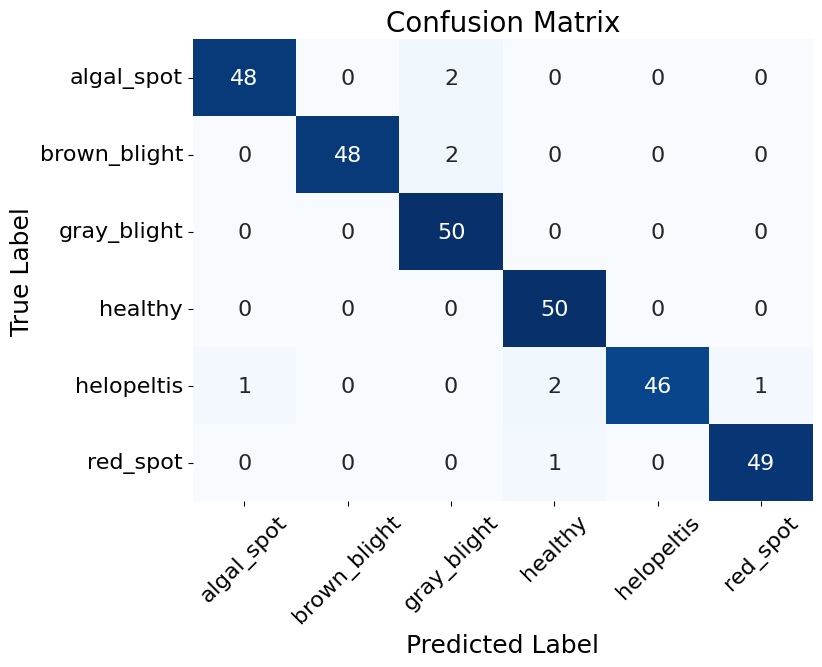

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9796    0.9600    0.9697        50
brown_blight     1.0000    0.9600    0.9796        50
 gray_blight     0.9259    1.0000    0.9615        50
     healthy     0.9434    1.0000    0.9709        50
  helopeltis     1.0000    0.9200    0.9583        50
    red_spot     0.9800    0.9800    0.9800        50

    accuracy                         0.9700       300
   macro avg     0.9715    0.9700    0.9700       300
weighted avg     0.9715    0.9700    0.9700       300

Accuracy: 0.9700
ROC AUC Score: 0.9969


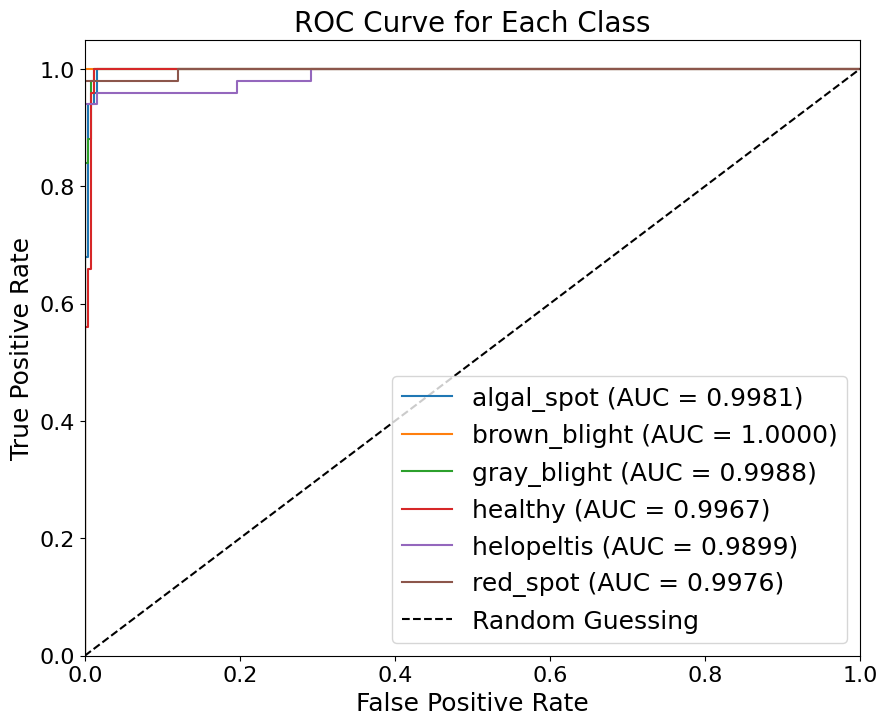

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [40]:
neuron = 512
name = f'neuron_{neuron}'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

neuron 256

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9800    0.9800    0.9800        50
brown_blight     0.9804    1.0000    0.9901        50
 gray_blight     0.9800    0.9800    0.9800        50
     healthy     0.9615    1.0000    0.9804        50
  helopeltis     1.0000    0.9600    0.9796        50
    red_spot     1.0000    0.9800    0.9899        50

    accuracy                         0.9833       300
   macro avg     0.9837    0.9833    0.9833       300
weighted avg     0.9837    0.9833    0.9833       300

Accuracy: 0.9833
ROC AUC Score: 0.9976


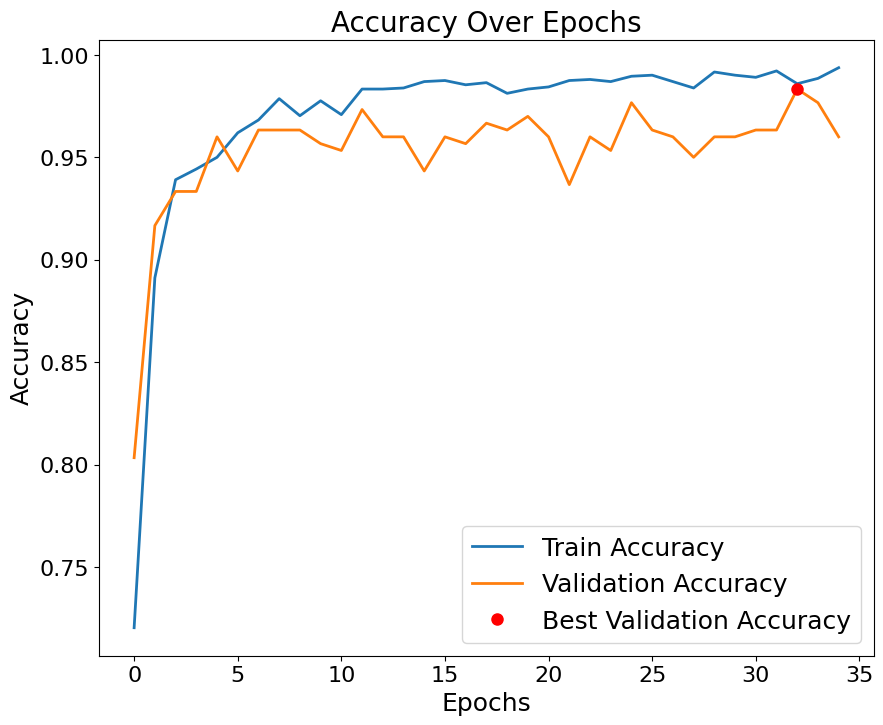

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [41]:
neuron = 256
name = f'neuron_{neuron}'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

neuron 128

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9608    0.9800    0.9703        50
brown_blight     0.9804    1.0000    0.9901        50
 gray_blight     0.9800    0.9800    0.9800        50
     healthy     0.9423    0.9800    0.9608        50
  helopeltis     1.0000    0.9200    0.9583        50
    red_spot     0.9800    0.9800    0.9800        50

    accuracy                         0.9733       300
   macro avg     0.9739    0.9733    0.9733       300
weighted avg     0.9739    0.9733    0.9733       300

Accuracy: 0.9733
ROC AUC Score: 0.9980


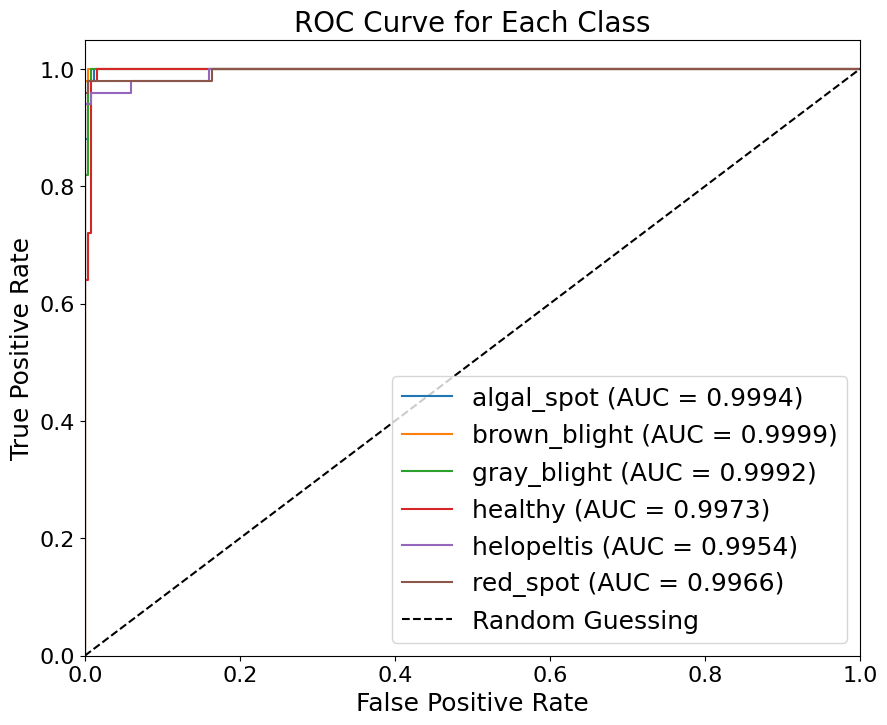

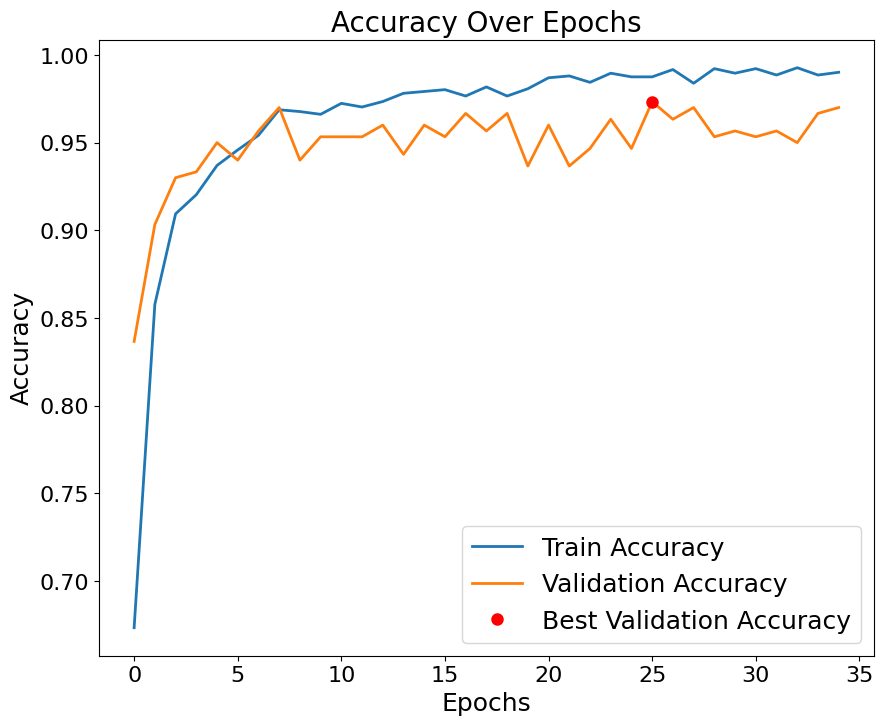

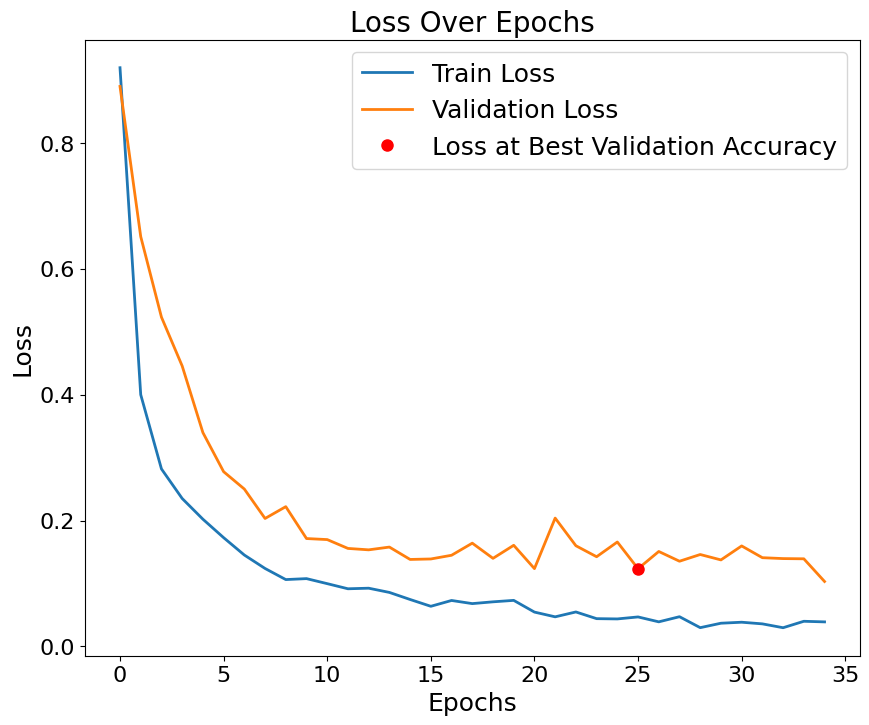

Model does not exist.
Keras session cleared.
TensorFlow session cleared.
Garbage collection completed.
TensorFlow graph reset.
Device /device:GPU:0 is available for TensorFlow.
GPU memory cleared.


In [43]:
neuron = 128
name = f'neuron_{neuron}'
model = build_model(neuron, image_size, dropout_rate, learning_rate, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)